# main nootbook to run

## installaions

## imports

In [20]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit,
    GridSearchCV,
    train_test_split,
    cross_validate,
    cross_val_score,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from econml.dr import DRLearner
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklift.models import SoloModel

from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re
from sklift.metrics import qini_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [21]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

In [22]:
from src.data_handler import DataHandler
from src.trainers import compare_train_test_performance, calculate_qini_auuc
from src.data_process import check_column_consistency,check_missing_values,dataset_health_check,check_column_consistency,check_missing_values,analyze_data_drift,dataset_health_check

## data handling

### data loading

In [23]:
# ----------------------------
# Load data
# ----------------------------
app_usage = pd.read_csv(repo_root / "data" / "train" / "app_usage.csv")
web_visits = pd.read_csv(repo_root / "data" / "train" / "web_visits.csv")
claims = pd.read_csv(repo_root / "data" / "train" / "claims.csv")
churn_labels = pd.read_csv(repo_root / "data" / "train" / "churn_labels.csv")
test_app_usage = pd.read_csv(repo_root / "data" / "test" / "test_app_usage.csv")
test_web_visits = pd.read_csv(repo_root / "data" / "test" / "test_web_visits.csv")
test_claims = pd.read_csv(repo_root / "data" / "test" / "test_claims.csv")
test_churn_labels = pd.read_csv(repo_root / "data" / "test" / "test_churn_labels.csv")

### data preprocess

In [24]:
train_data_handler = DataHandler(day_first_web=True)
test_data_handler = DataHandler(day_first_web=False)
X_train, y_train, treatment_train = train_data_handler.get_data(
    app_usage, web_visits, claims, churn_labels
)
X_test, y_test, treatment_test = test_data_handler.get_data(test_app_usage, test_web_visits, test_claims, test_churn_labels)



c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_usage_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_web_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_h

Feature matrix X shape: (10000, 31)
Target y distribution:
 y
0    7979
1    2021
Name: count, dtype: int64
Treatment distribution:
 treatment
0    6016
1    3984
Name: count, dtype: int64


c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_usage_trend).reset_index()
c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_web_trend).reset_index()


Feature matrix X shape: (10000, 31)
Target y distribution:
 y
0    7996
1    2004
Name: count, dtype: int64
Treatment distribution:
 treatment
0    6111
1    3889
Name: count, dtype: int64


c:\Users\elad\Desktop\rnd\VI\wellco_churn\src\data_handler.py:238: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("member_id").apply(self.calculate_claims_trend).reset_index()


In [25]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
treatment_train = treatment_train.fillna(0)
treatment_test = treatment_test.fillna(0)

     DATASET HEALTH CHECK STARTING     

--- 1. Column Consistency Check ---
✅ Column names are consistent across both datasets.
✅ Column order for common columns is the same.

--- 2. Missing Value (NaN) Check ---
✅ No NaNs found in X_train.

✅ No NaNs found in X_test.

--- 3. Data Drift Analysis and Visualization ---
Analyzing 31 numerical and 0 categorical features for drift.

> Numerical Drift (Distribution Shift):
  ✅ wellco_domain_visits: Mean shift is acceptable (0.02)
  ✅ late_claims: Mean shift is acceptable (0.01)
  ✅ ratio_wellco_domain: Mean shift is acceptable (-0.00)
  ✅ usage_trend: Mean shift is acceptable (-0.01)
  ✅ early_usage: Mean shift is acceptable (0.01)
  ✅ has_icd_J00: Mean shift is acceptable (-0.01)
  ✅ has_icd_M54_5: Mean shift is acceptable (0.00)
  ✅ early_claims: Mean shift is acceptable (0.01)
  ✅ has_icd_K21_9: Mean shift is acceptable (0.00)
  ✅ total_web_visits: Mean shift is acceptable (0.24)
  ✅ app_sessions: Mean shift is acceptable (0.02)
  ✅ has_

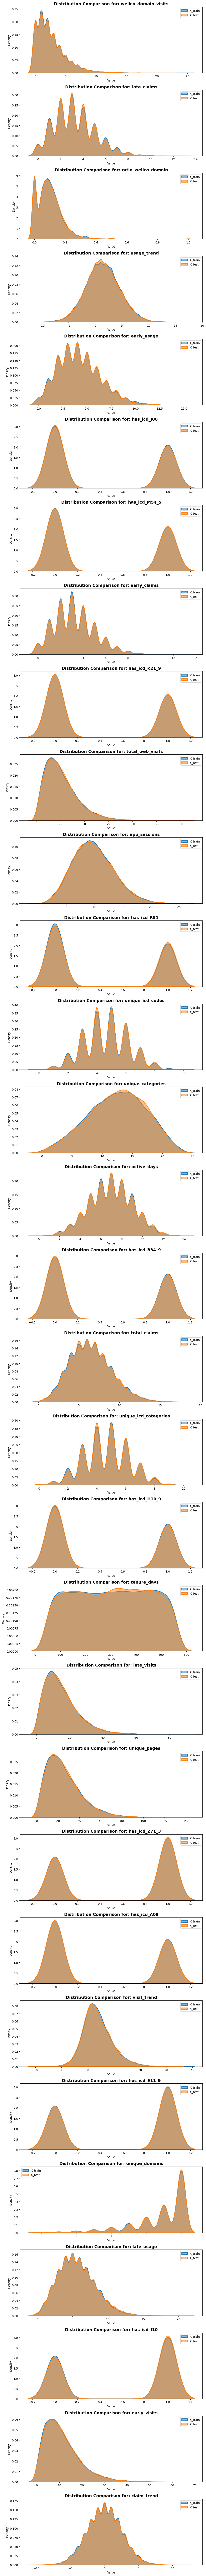


          HEALTH CHECK COMPLETE          


In [26]:


# --- Execution ---
dataset_health_check(X_train, X_test)

print("\n=========================================")
print("          HEALTH CHECK COMPLETE          ")
print("=========================================")

### feature selection

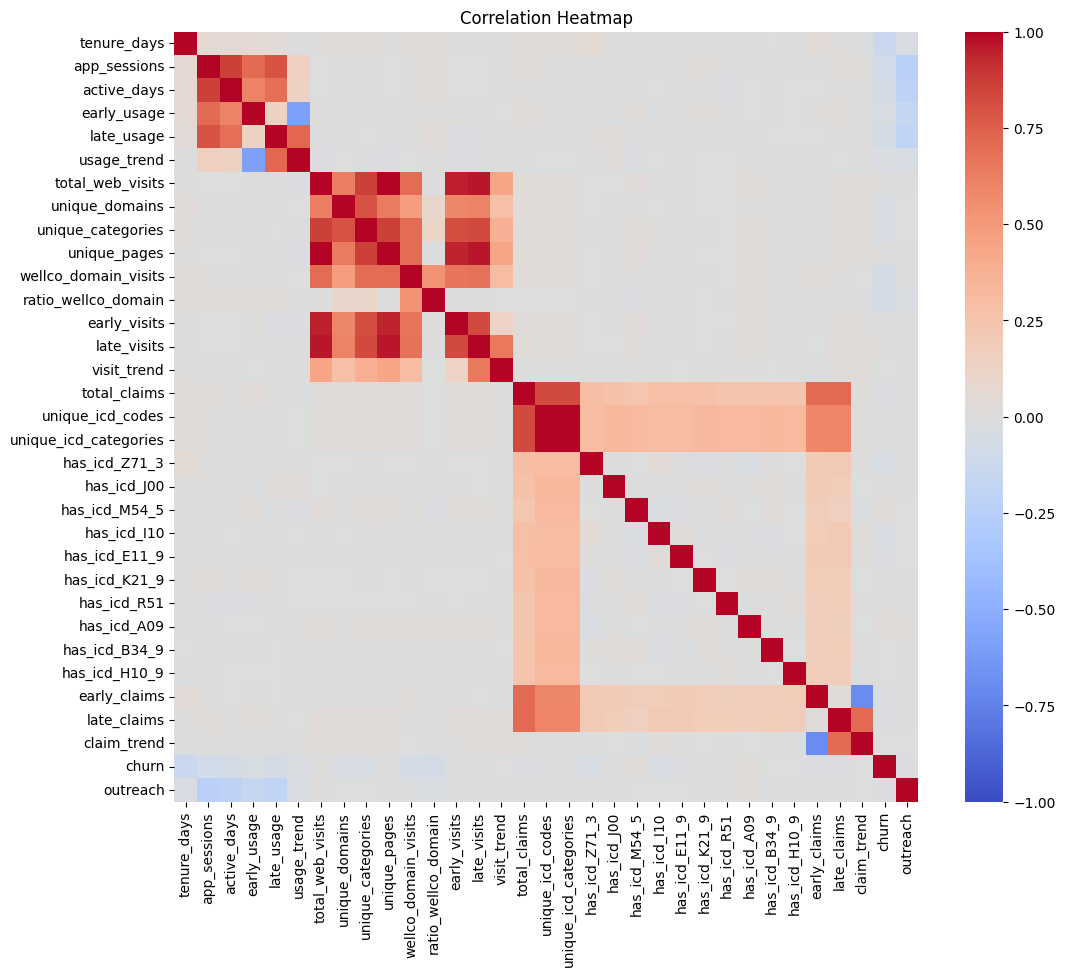

In [27]:


# Combine X_train with churn and outreach
X_train_with_labels = X_train.copy()
X_train_with_labels["churn"] = y_train
X_train_with_labels["outreach"] = treatment_train

# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

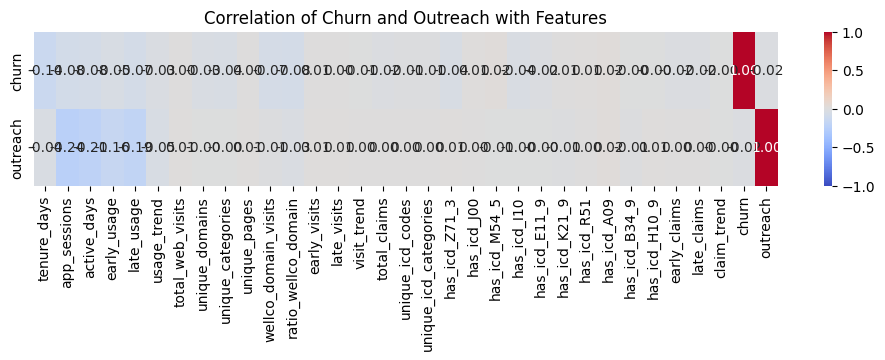

In [28]:
# Compute the correlation matrix
corr_matrix = X_train_with_labels.corr()

# Filter the correlation matrix to show only 'churn' and 'outreach' correlations with all features
filtered_corr = corr_matrix.loc[["churn", "outreach"]]

# Display the filtered correlation matrix
plt.figure(figsize=(12, 2))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation of Churn and Outreach with Features")
plt.show()

In [29]:
## Correlation Analysis: Identify Redundant Features

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get correlation matrix (already computed in previous cell)
corr_abs = corr_matrix.abs()

# 1. Find highly correlated feature pairs (threshold: 0.8)
upper_triangle = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
high_corr_pairs = []

for i in range(len(corr_abs.columns)):
    for j in range(i + 1, len(corr_abs.columns)):
        if corr_abs.iloc[i, j] > 0.8:
            high_corr_pairs.append(
                {
                    "Feature_1": corr_abs.columns[i],
                    "Feature_2": corr_abs.columns[j],
                    "Correlation": corr_abs.iloc[i, j],
                }
            )

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlation", ascending=False)

print("=" * 80)
print("HIGHLY CORRELATED FEATURES (|r| > 0.8)")
print("=" * 80)
if len(high_corr_df) > 0:
    print(high_corr_df.head(20).to_string(index=False))
    print(f"\nTotal pairs: {len(high_corr_df)}")
else:
    print("✅ No feature pairs with |correlation| > 0.8")

# 2. Check correlation with target (churn) and treatment (outreach)
target_corr = (
    corr_matrix[["churn", "outreach"]].abs().sort_values("churn", ascending=False)
)

print("\n" + "=" * 80)
print("FEATURE CORRELATION WITH CHURN & OUTREACH")
print("=" * 80)
print(target_corr.head(20).to_string())

# 3. Identify features to potentially drop
# Rule: If two features correlated > 0.8, drop the one with lower correlation to churn
features_to_drop = set()

for _, row in high_corr_df.iterrows():
    feat1, feat2 = row["Feature_1"], row["Feature_2"]

    # Skip if already marked for dropping
    if feat1 in features_to_drop or feat2 in features_to_drop:
        continue

    # Compare correlation with churn
    if feat1 in target_corr.index and feat2 in target_corr.index:
        corr1 = target_corr.loc[feat1, "churn"]
        corr2 = target_corr.loc[feat2, "churn"]

        # Drop the feature with weaker correlation to churn
        if corr1 < corr2:
            features_to_drop.add(feat1)
        else:
            features_to_drop.add(feat2)

print("\n" + "=" * 80)
print("RECOMMENDED FEATURES TO DROP (Redundant + Weak Churn Correlation)")
print("=" * 80)
if len(features_to_drop) > 0:
    print(f"Total features to drop: {len(features_to_drop)}")
    print(sorted(features_to_drop))
else:
    print("✅ No redundant features detected")

# 4. Variance Inflation Factor (VIF) check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric features (exclude target/treatment if still present)
numeric_cols = [
    col
    for col in X_train.columns
    if col not in ["churn", "outreach"] and X_train[col].dtype in ["float64", "int64"]
]

# Sample if too many features (VIF is slow)
if len(numeric_cols) > 50:
    print(
        f"\n⚠️  Sampling 50 features for VIF analysis (full dataset has {len(numeric_cols)} features)"
    )
    numeric_cols_sample = np.random.choice(numeric_cols, 50, replace=False).tolist()
else:
    numeric_cols_sample = numeric_cols

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols_sample
vif_data["VIF"] = [
    variance_inflation_factor(X_train[numeric_cols_sample].fillna(0).values, i)
    for i in range(len(numeric_cols_sample))
]
vif_data = vif_data.sort_values("VIF", ascending=False)

print("\n" + "=" * 80)
print("VARIANCE INFLATION FACTOR (VIF) - Top 20 Features")
print("VIF > 10 indicates severe multicollinearity")
print("=" * 80)
print(vif_data.head(20).to_string(index=False))

# 5. PCA Recommendation
print("\n" + "=" * 80)
print("PCA vs FEATURE SELECTION RECOMMENDATION")
print("=" * 80)

n_features = X_train.shape[1]
n_high_corr = len(high_corr_df)
n_vif_high = (vif_data["VIF"] > 10).sum()

print(f"\n📊 DATASET SUMMARY:")
print(f"   Total features: {n_features}")
print(f"   Highly correlated pairs: {n_high_corr}")
print(f"   Features with VIF > 10: {n_vif_high}")
print(f"   Recommended to drop: {len(features_to_drop)}")

print(f"\n💡 RECOMMENDATION:")

if n_high_corr > 20 or n_vif_high > 10:
    print("   ⚠️  HIGH MULTICOLLINEARITY DETECTED")
    print("   → Option 1: Drop redundant features (simple, interpretable)")
    print(
        "   → Option 2: Use PCA (loses interpretability, may help with regularization)"
    )
    print("\n   For WellCo uplift modeling (per data/wellco_client_brief.txt):")
    print("   ✅ RECOMMENDED: Drop redundant features")
    print("      - Preserves clinical interpretability (ICD-10 codes, claims_count)")
    print("      - LightGBM handles remaining collinearity well")
    print("   ❌ AVOID PCA for now:")
    print("      - Loses domain meaning (can't explain 'PC1' to clinicians)")
    print("      - Use only if dimensionality reduction is critical for compute")
else:
    print("   ✅ MODERATE MULTICOLLINEARITY")
    print(
        "   → Drop {0} redundant features (correlation > 0.8)".format(
            len(features_to_drop)
        )
    )
    print("   → PCA not needed — LightGBM handles remaining correlations")

# 6. Save features to drop for reproducibility
if len(features_to_drop) > 0:
    output_path = repo_root / "outputs" / f"features_to_drop_{timestamp}.txt"
    with open(output_path, "w") as f:
        f.write("\n".join(sorted(features_to_drop)))
    print(f"\n✅ Redundant features list saved to: {output_path}")

HIGHLY CORRELATED FEATURES (|r| > 0.8)
        Feature_1             Feature_2  Correlation
 unique_icd_codes unique_icd_categories     1.000000
 total_web_visits          unique_pages     0.999009
 total_web_visits           late_visits     0.968457
     unique_pages           late_visits     0.967300
 total_web_visits          early_visits     0.945446
     unique_pages          early_visits     0.944767
     app_sessions           active_days     0.863722
unique_categories          unique_pages     0.863531
 total_web_visits     unique_categories     0.859399
     early_visits           late_visits     0.834445
unique_categories           late_visits     0.831394
     total_claims      unique_icd_codes     0.829811
     total_claims unique_icd_categories     0.829811
unique_categories          early_visits     0.813687
   unique_domains     unique_categories     0.802554

Total pairs: 15

FEATURE CORRELATION WITH CHURN & OUTREACH
                         churn  outreach
churn       

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. 


VARIANCE INFLATION FACTOR (VIF) - Top 20 Features
VIF > 10 indicates severe multicollinearity
              Feature  VIF
         total_claims  inf
     unique_icd_codes  inf
          late_claims  inf
         early_claims  inf
        has_icd_H10_9  inf
        has_icd_B34_9  inf
          has_icd_A09  inf
          has_icd_R51  inf
        has_icd_K21_9  inf
        has_icd_E11_9  inf
          has_icd_I10  inf
        has_icd_M54_5  inf
          has_icd_J00  inf
        has_icd_Z71_3  inf
unique_icd_categories  inf
          claim_trend  inf
         app_sessions  inf
          visit_trend  inf
          late_visits  inf
         early_visits  inf

PCA vs FEATURE SELECTION RECOMMENDATION

📊 DATASET SUMMARY:
   Total features: 31
   Highly correlated pairs: 15
   Features with VIF > 10: 28
   Recommended to drop: 8

💡 RECOMMENDATION:
   ⚠️  HIGH MULTICOLLINEARITY DETECTED
   → Option 1: Drop redundant features (simple, interpretable)
   → Option 2: Use PCA (loses interpretability,

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. 

In [30]:
## Drop Redundant Features (If Recommended Above)

if len(features_to_drop) > 0:
    print(f"Dropping {len(features_to_drop)} redundant features...")
    X_train_reduced = X_train.drop(columns=list(features_to_drop))
    X_test_reduced = X_test.drop(columns=list(features_to_drop))

    print(f"Original shape: {X_train.shape}")
    print(f"Reduced shape:  {X_train_reduced.shape}")

    # Use X_train_reduced for modeling
else:
    print("No features to drop — proceed with current feature set")
    X_train_reduced = X_train.copy()
    X_test_reduced = X_test.copy()

Dropping 8 redundant features...
Original shape: (10000, 31)
Reduced shape:  (10000, 23)


In [31]:
train_data_outreach_grouped = X_train_reduced.groupby(treatment_train).mean()
train_data_outreach_grouped

tenure_days  app_sessions  early_usage  late_usage  usage_trend  \
treatment                                                                    
0           307.287733     10.480386     4.479222    6.001164     1.521941   
1           295.533133      8.719629     3.745733    4.973896     1.228163   

           unique_categories  wellco_domain_visits  ratio_wellco_domain  \
treatment                                                                 
0                  12.460771              2.553524             0.098863   
1                  12.451305              2.488956             0.094349   

           visit_trend  total_claims  ...  has_icd_I10  has_icd_E11_9  \
treatment                             ...                               
0             3.790725      6.448637  ...     0.589761       0.589761   
1             3.815010      6.471135  ...     0.587098       0.585341   

           has_icd_K21_9  has_icd_R51  has_icd_A09  has_icd_B34_9  \
treatment                                                           
0               0.410239     0.404255     0.406250       0.423537   
1               0.400100     0.404367     0.425452       0.415161   

           has_icd_H10_9  early_claims  late_claims  claim_trend  
treatment                                                         
0               0.412234      3.226895     3.221742    -0.005153  
1               0.421436      3.244729     3.226406    -0.018323  

[2 rows x 23 columns]

In [32]:
train_data_outreach_grouped = X_train.groupby(treatment_train).mean()
train_data_outreach_grouped

tenure_days  app_sessions  active_days  early_usage  late_usage  \
treatment                                                                    
0           307.287733     10.480386     7.321809     4.479222    6.001164   
1           295.533133      8.719629     6.430221     3.745733    4.973896   

           usage_trend  total_web_visits  unique_domains  unique_categories  \
treatment                                                                     
0             1.521941         25.772773        6.858544          12.460771   
1             1.228163         26.177460        6.853665          12.451305   

           unique_pages  ...  has_icd_I10  has_icd_E11_9  has_icd_K21_9  \
treatment                ...                                              
0             25.241689  ...     0.589761       0.589761       0.410239   
1             25.650853  ...     0.587098       0.585341       0.400100   

           has_icd_R51  has_icd_A09  has_icd_B34_9  has_icd_H10_9  \
treatment                                                           
0             0.404255     0.406250       0.423537       0.412234   
1             0.404367     0.425452       0.415161       0.421436   

           early_claims  late_claims  claim_trend  
treatment                                          
0              3.226895     3.221742    -0.005153  
1              3.244729     3.226406    -0.018323  

[2 rows x 31 columns]


TREATMENT EFFECT BY TENURE_DAYS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low tenure_days -0.008696     3343       1422       1921       0.265120       0.273816
Medium tenure_days -0.007059     3339       1274       2065       0.181319       0.188378
  High tenure_days -0.035934     3318       1288       2030       0.128106       0.164039

Overall ATE (reference): -0.0134


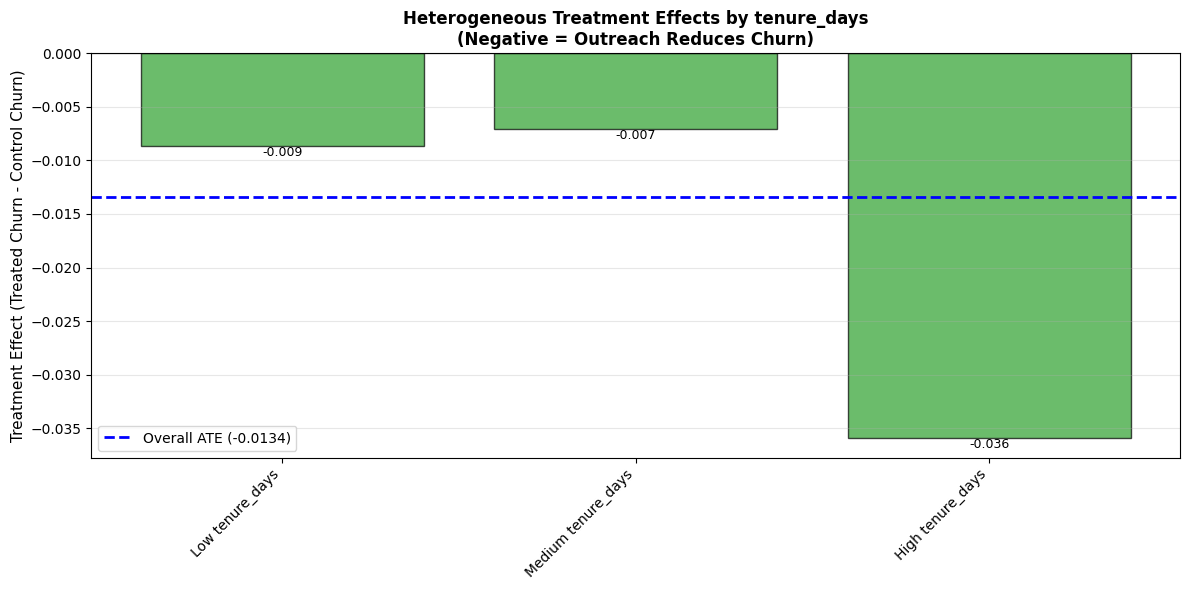


💡 CLINICAL INSIGHT for tenure_days:
   ✅ BEST: High tenure_days shows strongest benefit (ATE=-0.0359)
      → Prioritize outreach for this segment (3318 members)

TREATMENT EFFECT BY APP_SESSIONS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low app_sessions -0.027522     3840       1994       1846       0.221665       0.249187
Medium app_sessions -0.015882     3167       1220       1947       0.184426       0.200308
  High app_sessions -0.041375     2993        770       2223       0.137662       0.179037

Overall ATE (reference): -0.0134


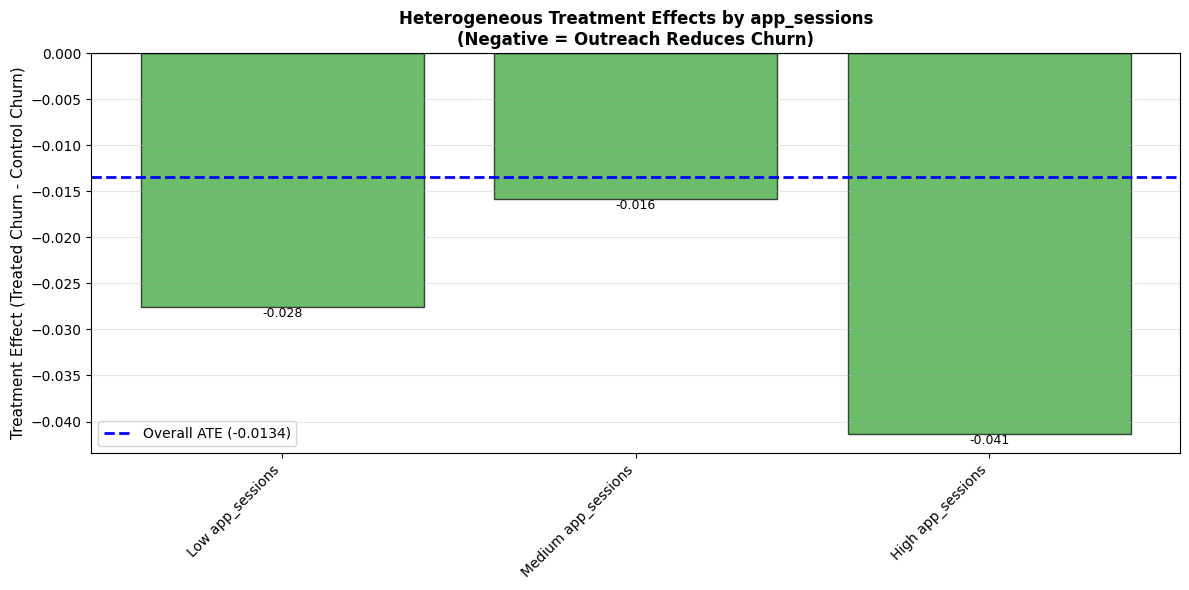


💡 CLINICAL INSIGHT for app_sessions:
   ✅ BEST: High app_sessions shows strongest benefit (ATE=-0.0414)
      → Prioritize outreach for this segment (2993 members)

TREATMENT EFFECT BY ACTIVE_DAYS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low active_days -0.021977     4114       2064       2050       0.218023       0.240000
Medium active_days -0.024217     3538       1299       2239       0.181678       0.205895
  High active_days -0.030720     2348        621       1727       0.140097       0.170816

Overall ATE (reference): -0.0134


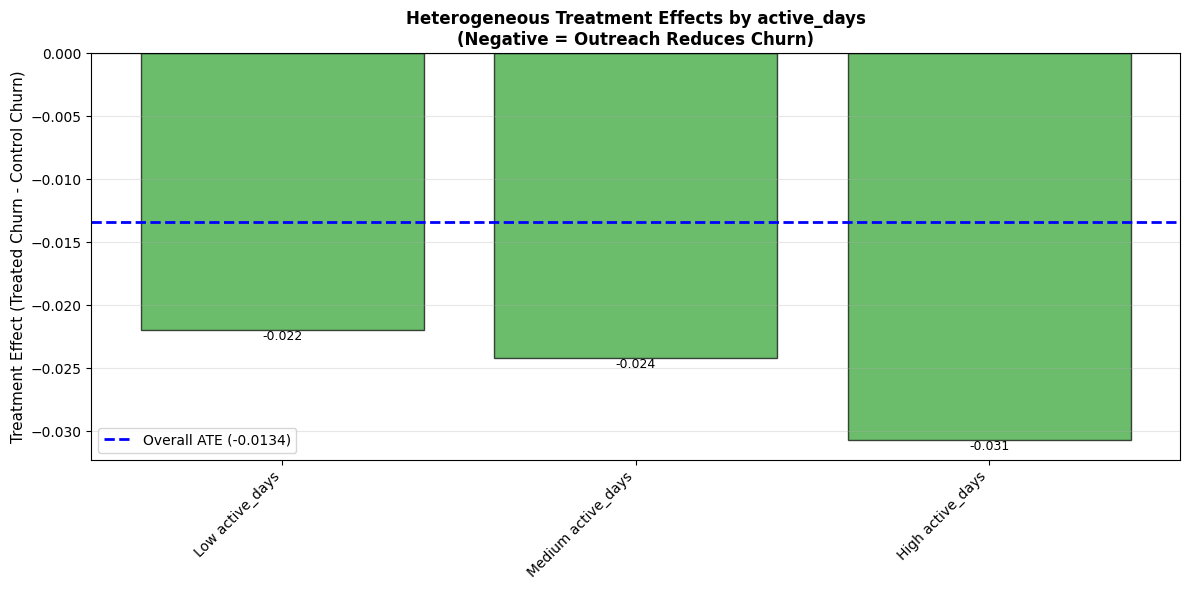


💡 CLINICAL INSIGHT for active_days:
   ✅ BEST: High active_days shows strongest benefit (ATE=-0.0307)
      → Prioritize outreach for this segment (2348 members)

TREATMENT EFFECT BY EARLY_USAGE LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_usage -0.016082     4141       1971       2170       0.211568       0.227650
Medium early_usage -0.020361     3293       1236       2057       0.182848       0.203209
  High early_usage -0.020504     2566        777       1789       0.167310       0.187814

Overall ATE (reference): -0.0134


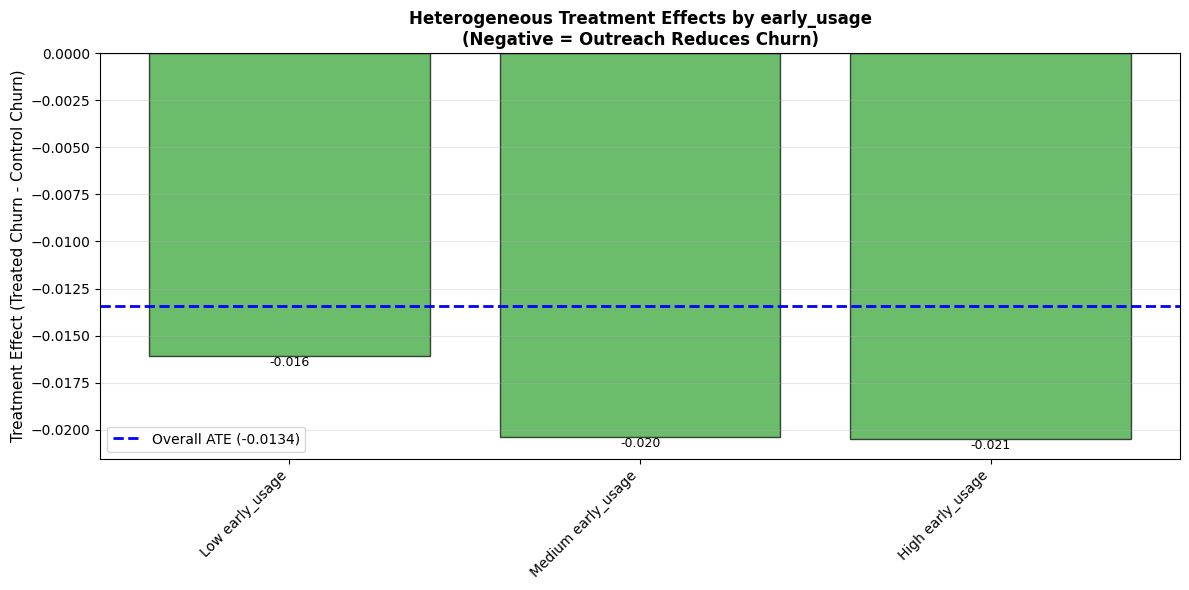


💡 CLINICAL INSIGHT for early_usage:
   ✅ BEST: High early_usage shows strongest benefit (ATE=-0.0205)
      → Prioritize outreach for this segment (2566 members)

TREATMENT EFFECT BY LATE_USAGE LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_usage -0.011727     3649       1845       1804       0.223306       0.235033
Medium late_usage -0.037844     4152       1545       2607       0.177346       0.215190
  High late_usage -0.017398     2199        594       1605       0.146465       0.163863

Overall ATE (reference): -0.0134


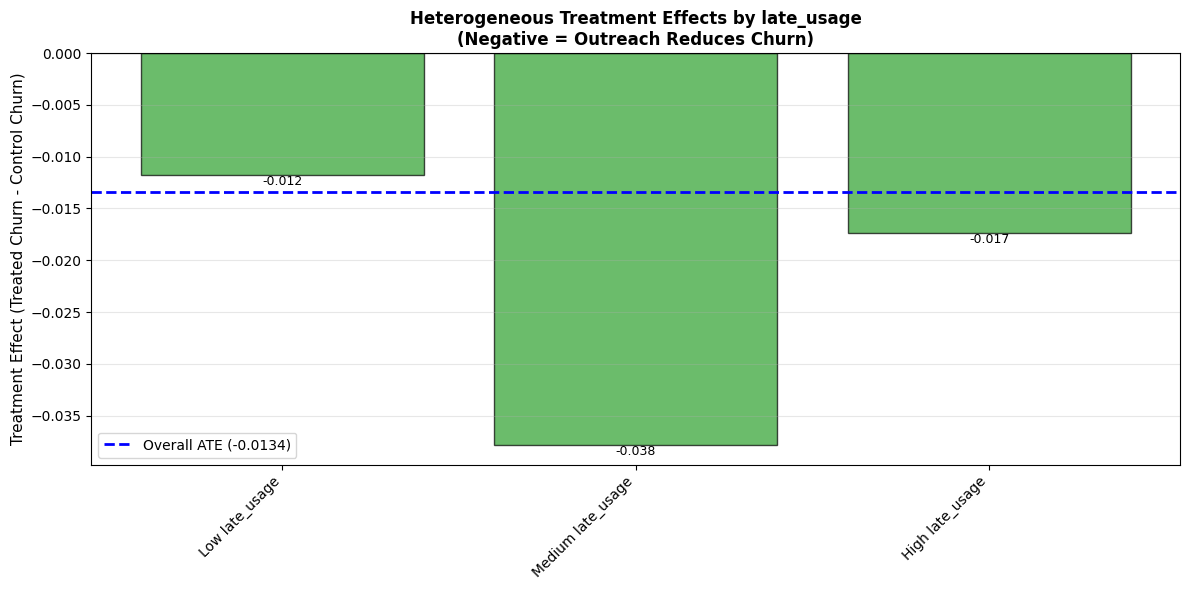


💡 CLINICAL INSIGHT for late_usage:
   ✅ BEST: Medium late_usage shows strongest benefit (ATE=-0.0378)
      → Prioritize outreach for this segment (4152 members)

TREATMENT EFFECT BY USAGE_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low usage_trend -0.013870     3938       1668       2270       0.206835       0.220705
Medium usage_trend -0.011074     3627       1451       2176       0.194349       0.205423
  High usage_trend -0.022297     2435        865       1570       0.168786       0.191083

Overall ATE (reference): -0.0134


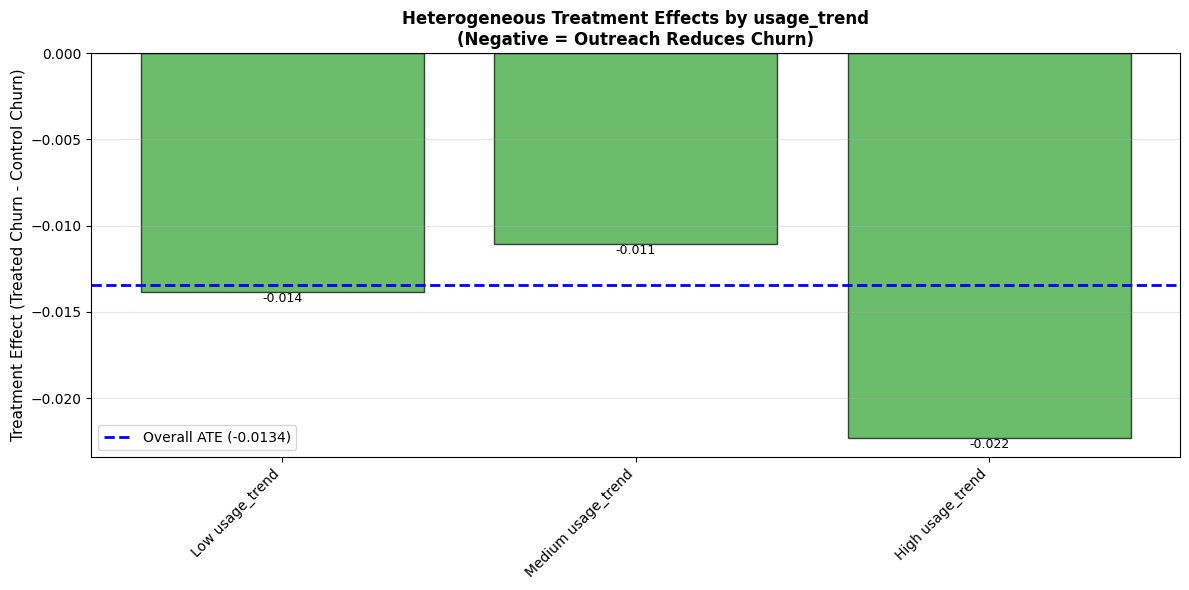


💡 CLINICAL INSIGHT for usage_trend:
   ✅ BEST: High usage_trend shows strongest benefit (ATE=-0.0223)
      → Prioritize outreach for this segment (2435 members)

TREATMENT EFFECT BY TOTAL_WEB_VISITS LEVEL
                Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low total_web_visits -0.034661     3413       1355       2058       0.183026       0.217687
Medium total_web_visits  0.002331     3346       1322       2024       0.200454       0.198123
  High total_web_visits -0.007379     3241       1307       1934       0.198929       0.206308

Overall ATE (reference): -0.0134


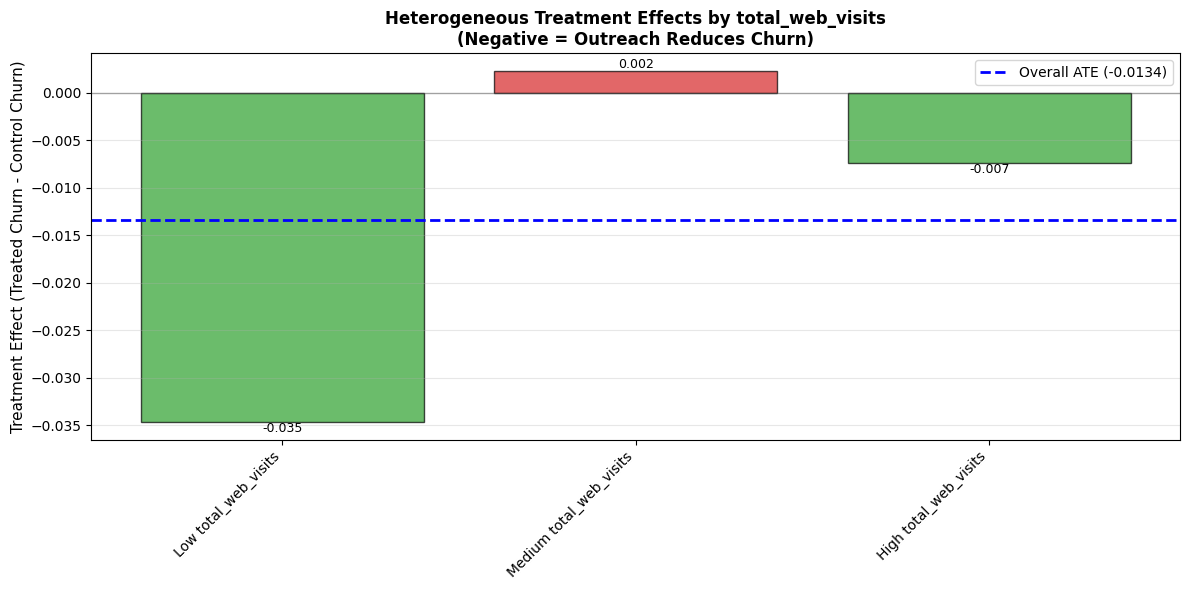


💡 CLINICAL INSIGHT for total_web_visits:
   ✅ BEST: Low total_web_visits shows strongest benefit (ATE=-0.0347)
      → Prioritize outreach for this segment (3413 members)
   ⚠️  WORST: Medium total_web_visits shows harm/no benefit (ATE=0.0023)
      → Avoid outreach for this segment (3346 members)

❌ Error processing 'unique_domains': Bin labels must be one fewer than the number of bin edges

TREATMENT EFFECT BY UNIQUE_CATEGORIES LEVEL
                 Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_categories -0.028932     3409       1363       2046       0.203228       0.232160
Medium unique_categories -0.002866     3750       1498       2252       0.208945       0.211812
  High unique_categories -0.009337     2841       1123       1718       0.162956       0.172293

Overall ATE (reference): -0.0134


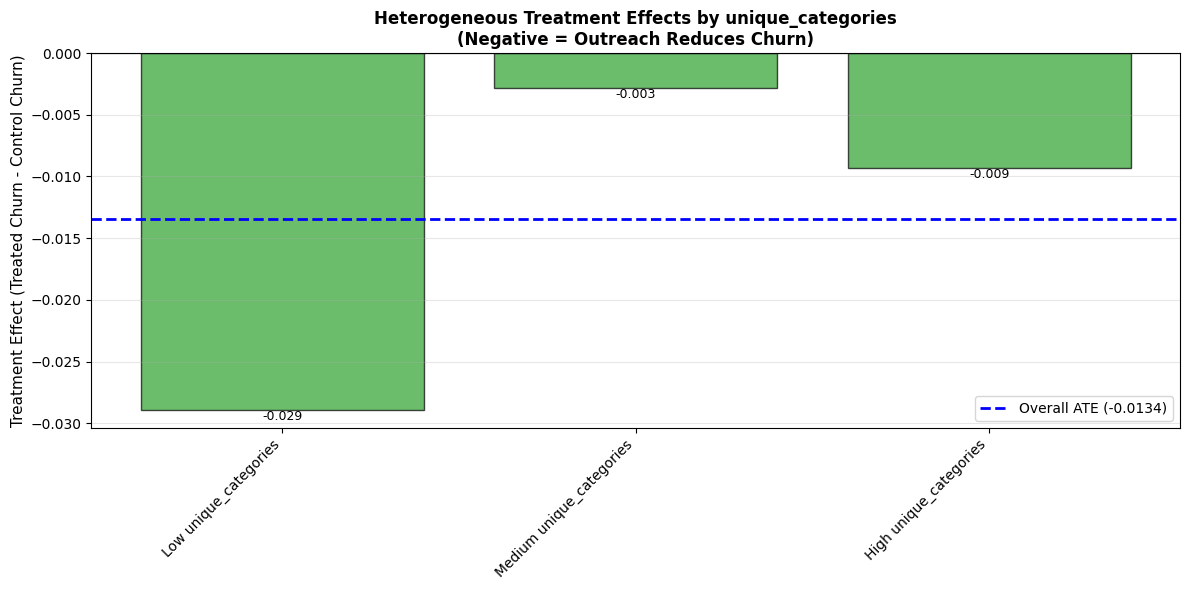


💡 CLINICAL INSIGHT for unique_categories:
   ✅ BEST: Low unique_categories shows strongest benefit (ATE=-0.0289)
      → Prioritize outreach for this segment (3409 members)

TREATMENT EFFECT BY UNIQUE_PAGES LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_pages -0.036706     3453       1365       2088       0.181685       0.218391
Medium unique_pages  0.007379     3239       1283       1956       0.204209       0.196830
  High unique_pages -0.009533     3308       1336       1972       0.196856       0.206389

Overall ATE (reference): -0.0134


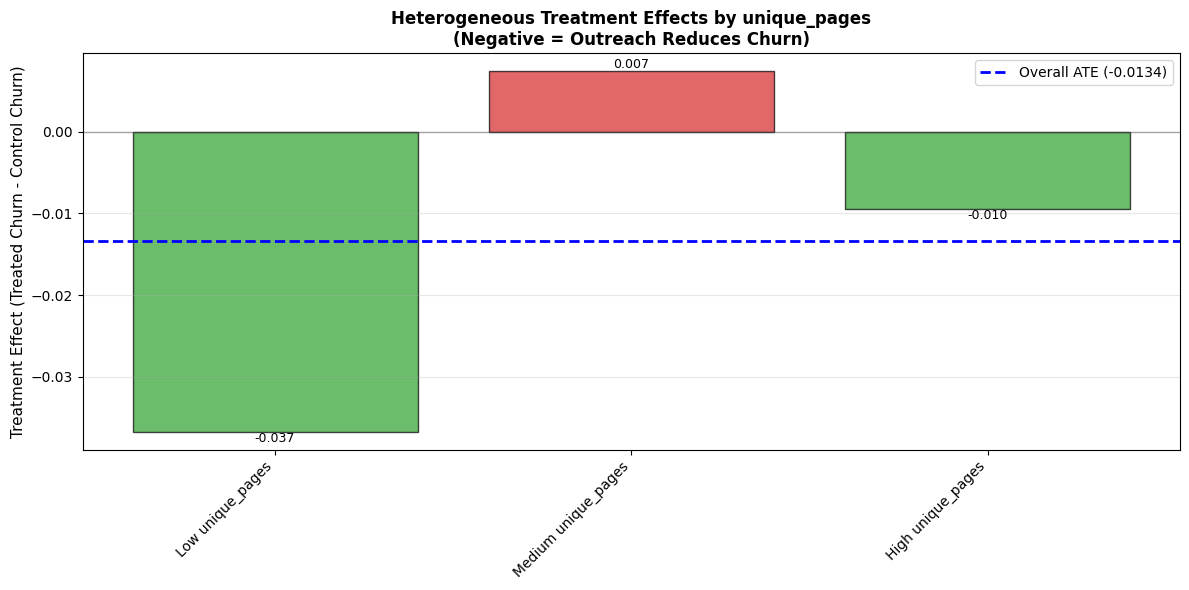


💡 CLINICAL INSIGHT for unique_pages:
   ✅ BEST: Low unique_pages shows strongest benefit (ATE=-0.0367)
      → Prioritize outreach for this segment (3453 members)
   ⚠️  WORST: Medium unique_pages shows harm/no benefit (ATE=0.0074)
      → Avoid outreach for this segment (3239 members)

TREATMENT EFFECT BY WELLCO_DOMAIN_VISITS LEVEL
                    Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low wellco_domain_visits -0.023597     4076       1646       2430       0.213852       0.237449
Medium wellco_domain_visits -0.025144     3276       1331       1945       0.192337       0.217481
  High wellco_domain_visits  0.012726     2648       1007       1641       0.163853       0.151127

Overall ATE (reference): -0.0134


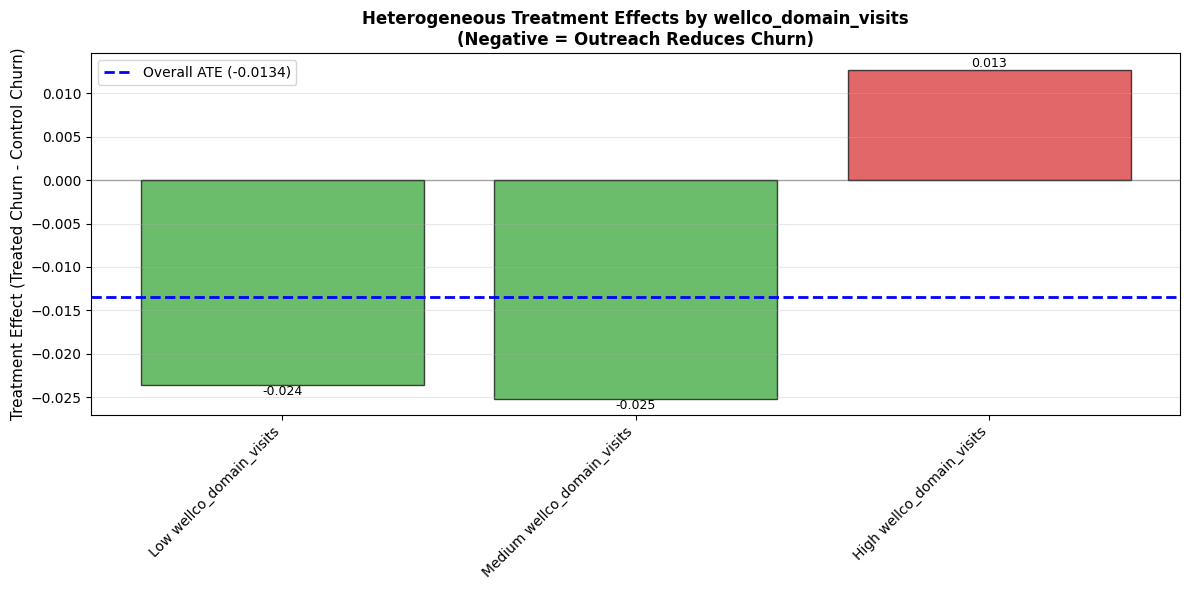


💡 CLINICAL INSIGHT for wellco_domain_visits:
   ✅ BEST: Medium wellco_domain_visits shows strongest benefit (ATE=-0.0251)
      → Prioritize outreach for this segment (3276 members)
   ⚠️  WORST: High wellco_domain_visits shows harm/no benefit (ATE=0.0127)
      → Avoid outreach for this segment (2648 members)

TREATMENT EFFECT BY RATIO_WELLCO_DOMAIN LEVEL
                   Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low ratio_wellco_domain -0.030868     3389       1393       1996       0.231156       0.262024
Medium ratio_wellco_domain -0.023959     3318       1313       2005       0.182026       0.205985
  High ratio_wellco_domain  0.011045     3293       1278       2015       0.165884       0.154839

Overall ATE (reference): -0.0134


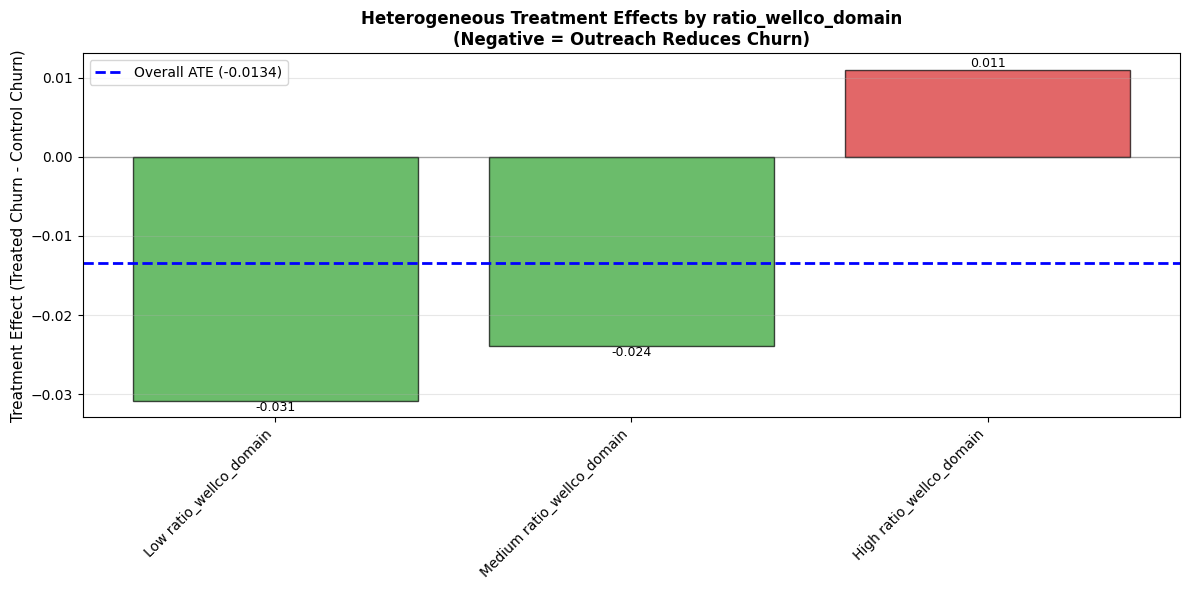


💡 CLINICAL INSIGHT for ratio_wellco_domain:
   ✅ BEST: Low ratio_wellco_domain shows strongest benefit (ATE=-0.0309)
      → Prioritize outreach for this segment (3389 members)
   ⚠️  WORST: High ratio_wellco_domain shows harm/no benefit (ATE=0.0110)
      → Avoid outreach for this segment (3293 members)

TREATMENT EFFECT BY EARLY_VISITS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_visits -0.034328     3827       1499       2328       0.183456       0.217784
Medium early_visits  0.002279     3111       1249       1862       0.196157       0.193878
  High early_visits -0.003413     3062       1236       1826       0.204693       0.208105

Overall ATE (reference): -0.0134


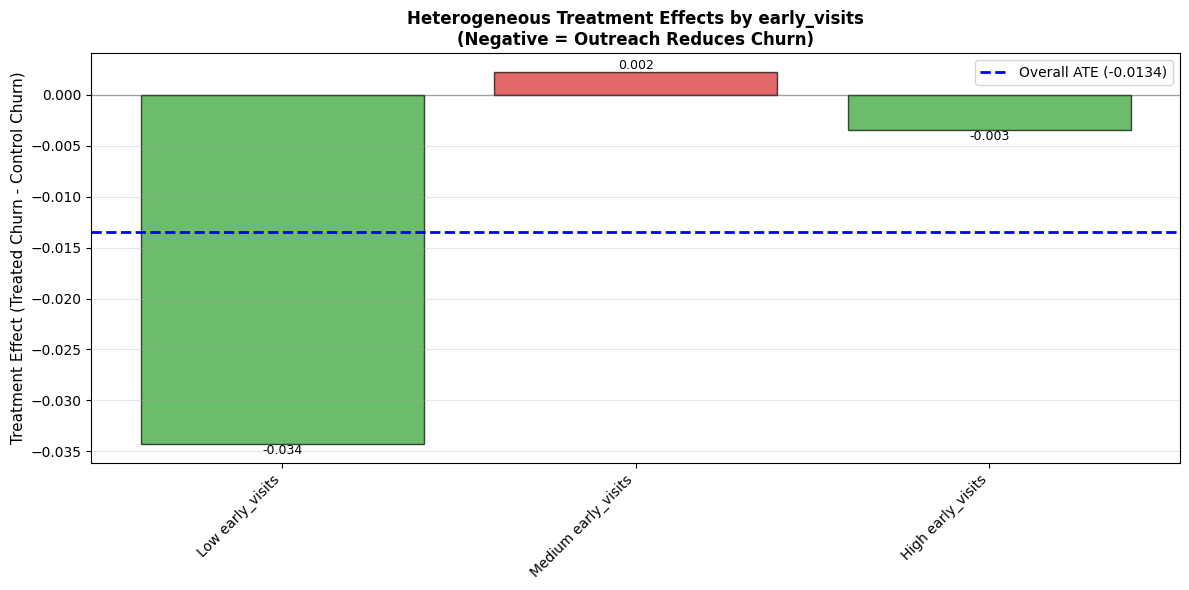


💡 CLINICAL INSIGHT for early_visits:
   ✅ BEST: Low early_visits shows strongest benefit (ATE=-0.0343)
      → Prioritize outreach for this segment (3827 members)
   ⚠️  WORST: Medium early_visits shows harm/no benefit (ATE=0.0023)
      → Avoid outreach for this segment (3111 members)

TREATMENT EFFECT BY LATE_VISITS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_visits -0.021456     3514       1397       2117       0.189692       0.211148
Medium late_visits -0.023537     3239       1266       1973       0.183254       0.206792
  High late_visits  0.004883     3247       1321       1926       0.208933       0.204050

Overall ATE (reference): -0.0134


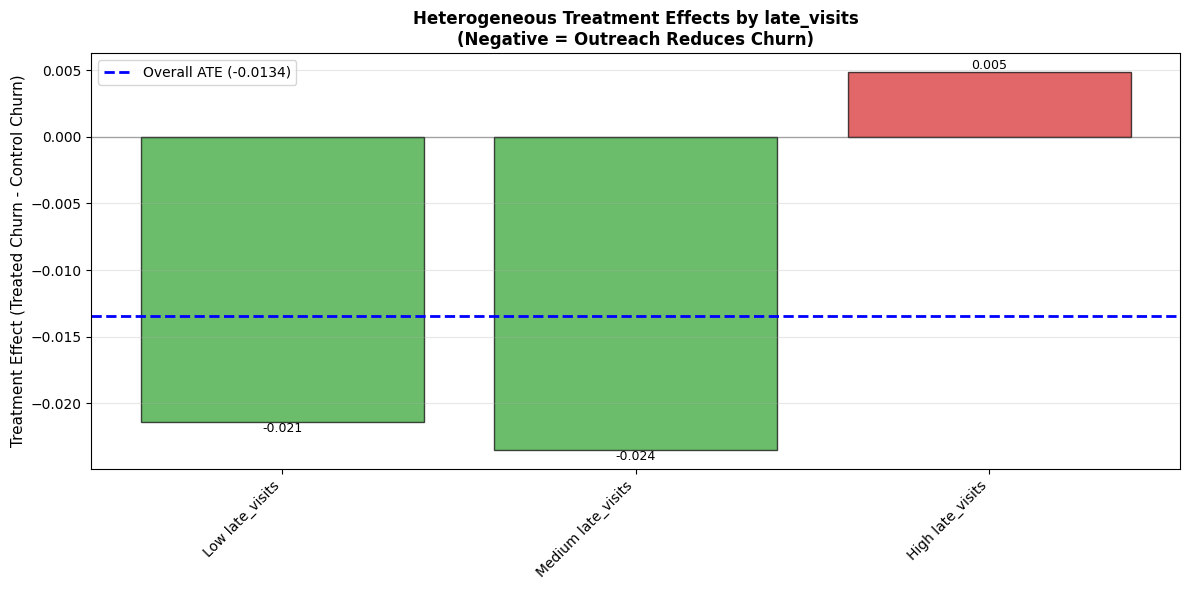


💡 CLINICAL INSIGHT for late_visits:
   ✅ BEST: Medium late_visits shows strongest benefit (ATE=-0.0235)
      → Prioritize outreach for this segment (3239 members)
   ⚠️  WORST: High late_visits shows harm/no benefit (ATE=0.0049)
      → Avoid outreach for this segment (3247 members)

TREATMENT EFFECT BY VISIT_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low visit_trend -0.010523     3657       1465       2192       0.193857       0.204380
Medium visit_trend -0.020475     3105       1214       1891       0.196870       0.217345
  High visit_trend -0.009671     3238       1305       1933       0.191571       0.201242

Overall ATE (reference): -0.0134


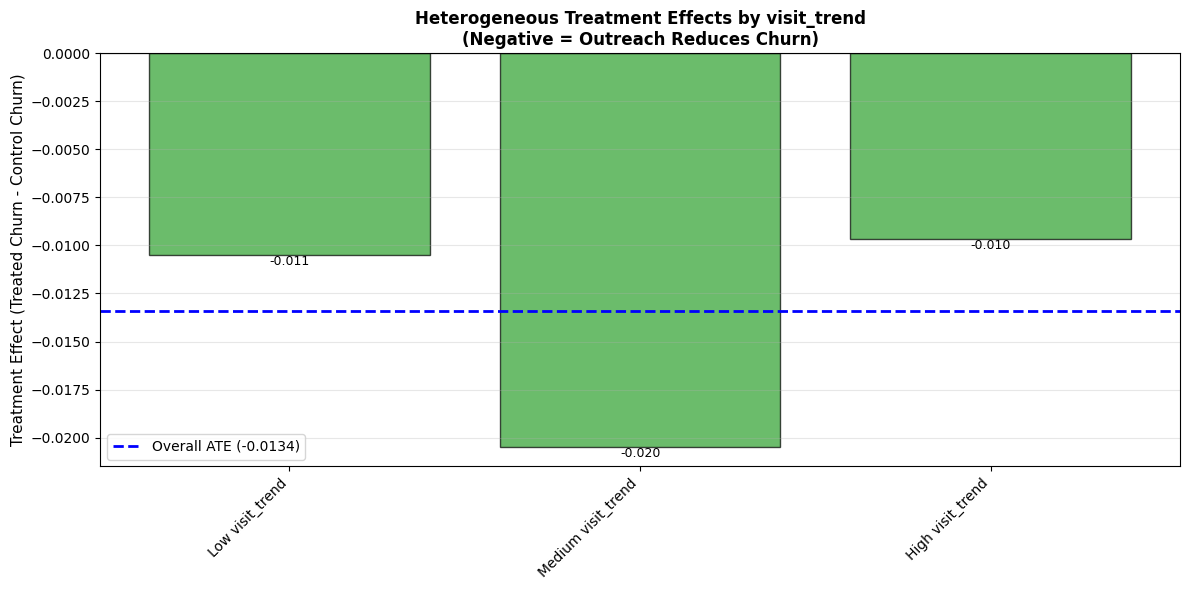


💡 CLINICAL INSIGHT for visit_trend:
   ✅ BEST: Medium visit_trend shows strongest benefit (ATE=-0.0205)
      → Prioritize outreach for this segment (3105 members)

TREATMENT EFFECT BY TOTAL_CLAIMS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low total_claims -0.026463     3798       1514       2284       0.196830       0.223292
Medium total_claims -0.012966     2979       1197       1782       0.192982       0.205948
  High total_claims  0.001417     3223       1273       1950       0.191673       0.190256

Overall ATE (reference): -0.0134


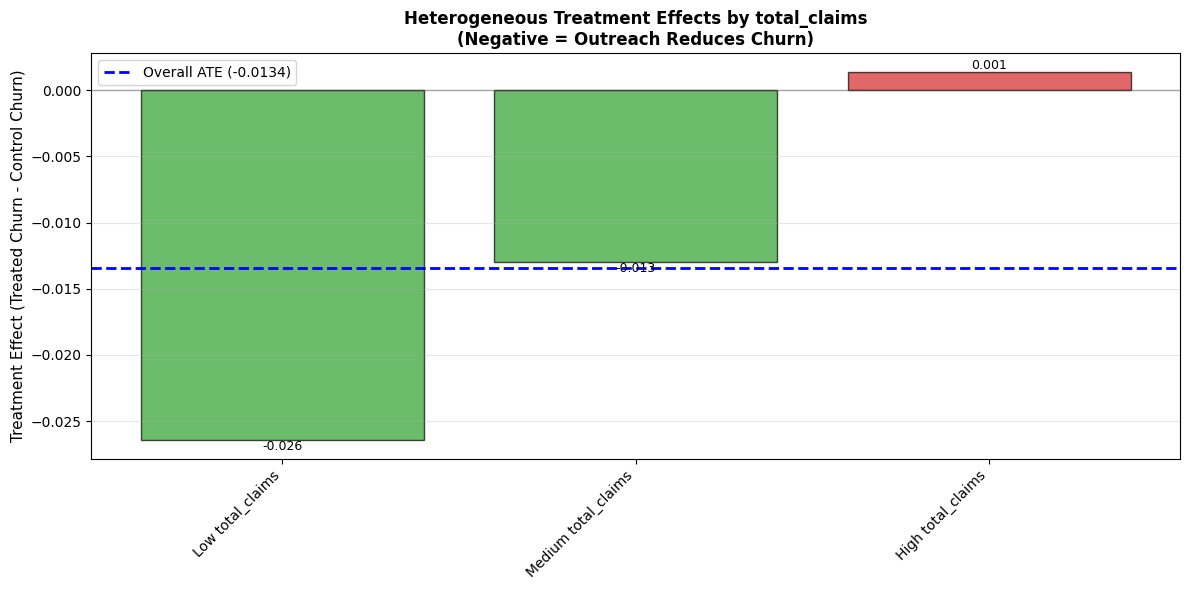


💡 CLINICAL INSIGHT for total_claims:
   ✅ BEST: Low total_claims shows strongest benefit (ATE=-0.0265)
      → Prioritize outreach for this segment (3798 members)
   ⚠️  WORST: High total_claims shows harm/no benefit (ATE=0.0014)
      → Avoid outreach for this segment (3223 members)

TREATMENT EFFECT BY UNIQUE_ICD_CODES LEVEL
                Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_icd_codes -0.024622     4613       1865       2748       0.195174       0.219796
Medium unique_icd_codes -0.016731     2431        951       1480       0.191377       0.208108
  High unique_icd_codes  0.006430     2956       1168       1788       0.194349       0.187919

Overall ATE (reference): -0.0134


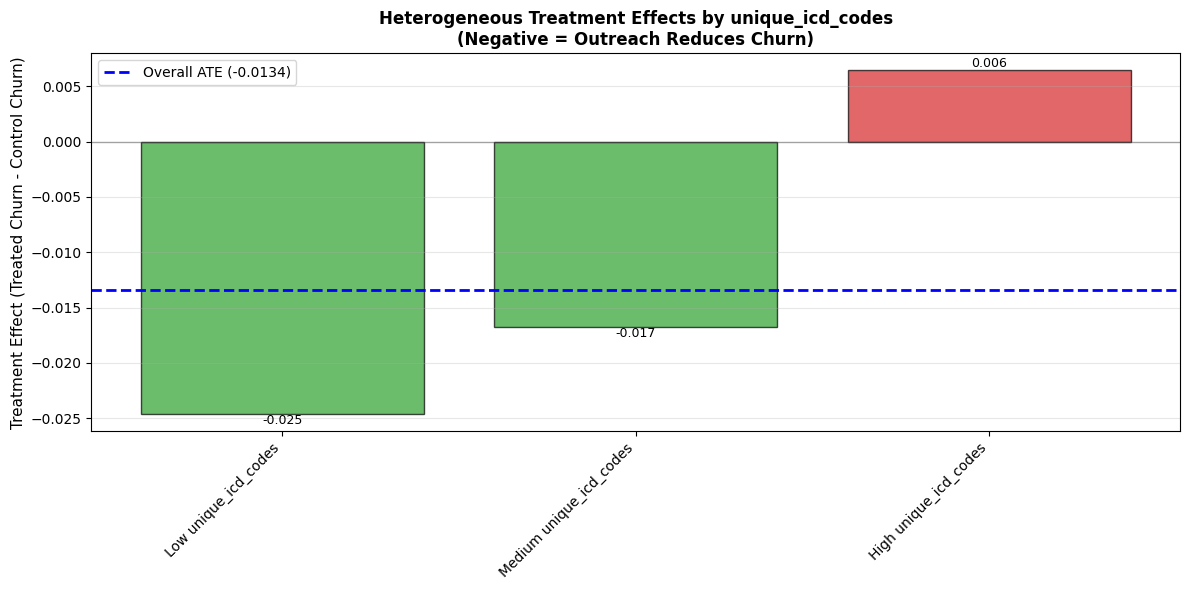


💡 CLINICAL INSIGHT for unique_icd_codes:
   ✅ BEST: Low unique_icd_codes shows strongest benefit (ATE=-0.0246)
      → Prioritize outreach for this segment (4613 members)
   ⚠️  WORST: High unique_icd_codes shows harm/no benefit (ATE=0.0064)
      → Avoid outreach for this segment (2956 members)

TREATMENT EFFECT BY UNIQUE_ICD_CATEGORIES LEVEL
                     Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low unique_icd_categories -0.024622     4613       1865       2748       0.195174       0.219796
Medium unique_icd_categories -0.016731     2431        951       1480       0.191377       0.208108
  High unique_icd_categories  0.006430     2956       1168       1788       0.194349       0.187919

Overall ATE (reference): -0.0134


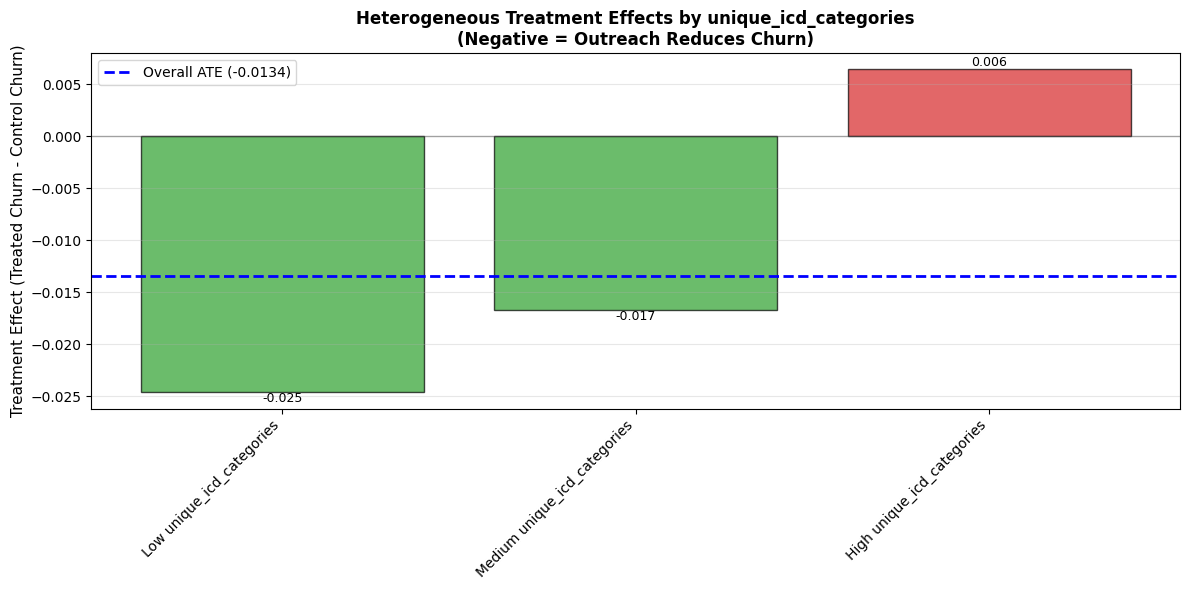


💡 CLINICAL INSIGHT for unique_icd_categories:
   ✅ BEST: Low unique_icd_categories shows strongest benefit (ATE=-0.0246)
      → Prioritize outreach for this segment (4613 members)
   ⚠️  WORST: High unique_icd_categories shows harm/no benefit (ATE=0.0064)
      → Avoid outreach for this segment (2956 members)

TREATMENT EFFECT BY HAS_ICD_Z71_3 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_Z71_3 -0.012038     4104       1610       2494       0.214907       0.226945
1.0 has_icd_Z71_3 -0.013775     5896       2374       3522       0.179865       0.193640

Overall ATE (reference): -0.0134


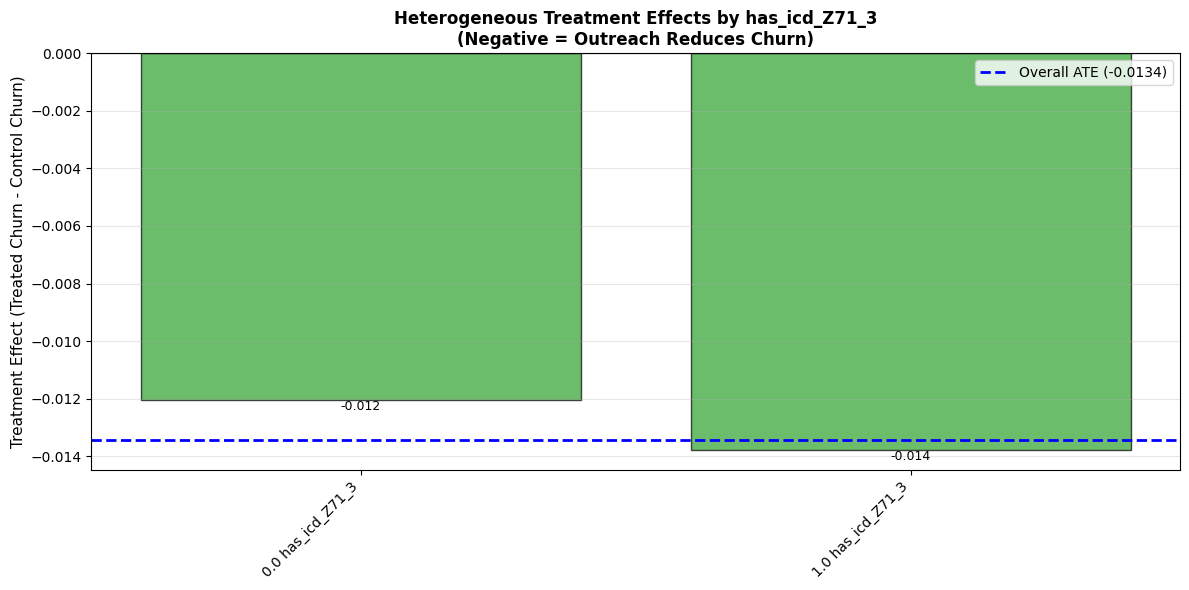


💡 CLINICAL INSIGHT for has_icd_Z71_3:
   ✅ BEST: 1.0 has_icd_Z71_3 shows strongest benefit (ATE=-0.0138)
      → Prioritize outreach for this segment (5896 members)

TREATMENT EFFECT BY HAS_ICD_J00 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_J00 -0.008700     5892       2336       3556       0.193493       0.202193
1.0 has_icd_J00 -0.020259     4108       1648       2460       0.194782       0.215041

Overall ATE (reference): -0.0134


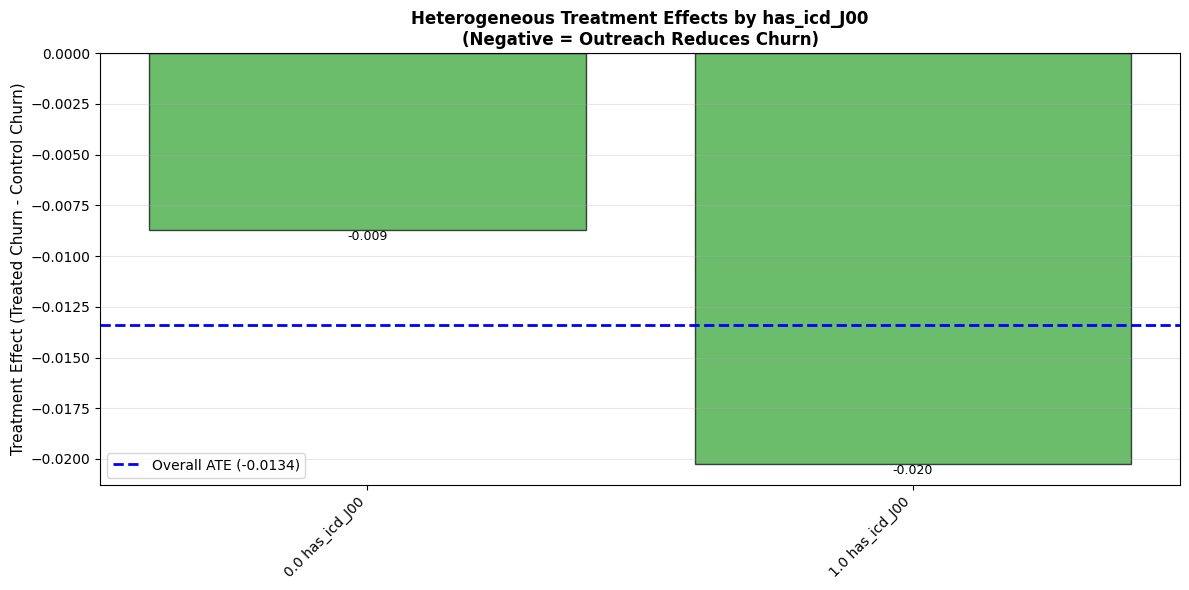


💡 CLINICAL INSIGHT for has_icd_J00:
   ✅ BEST: 1.0 has_icd_J00 shows strongest benefit (ATE=-0.0203)
      → Prioritize outreach for this segment (4108 members)

TREATMENT EFFECT BY HAS_ICD_M54_5 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_M54_5 -0.009877     5846       2347       3499       0.188752       0.198628
1.0 has_icd_M54_5 -0.018118     4154       1637       2517       0.201588       0.219706

Overall ATE (reference): -0.0134


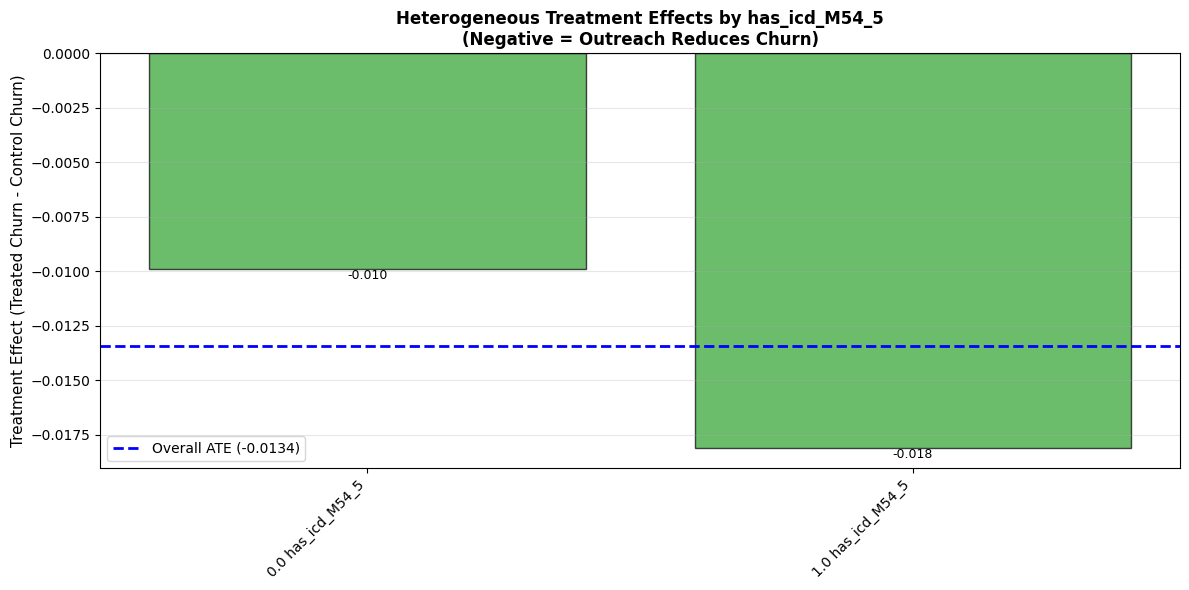


💡 CLINICAL INSIGHT for has_icd_M54_5:
   ✅ BEST: 1.0 has_icd_M54_5 shows strongest benefit (ATE=-0.0181)
      → Prioritize outreach for this segment (4154 members)

TREATMENT EFFECT BY HAS_ICD_I10 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_I10 -0.030551     4113       1645       2468       0.202432       0.232982
1.0 has_icd_I10 -0.001570     5887       2339       3548       0.188115       0.189684

Overall ATE (reference): -0.0134


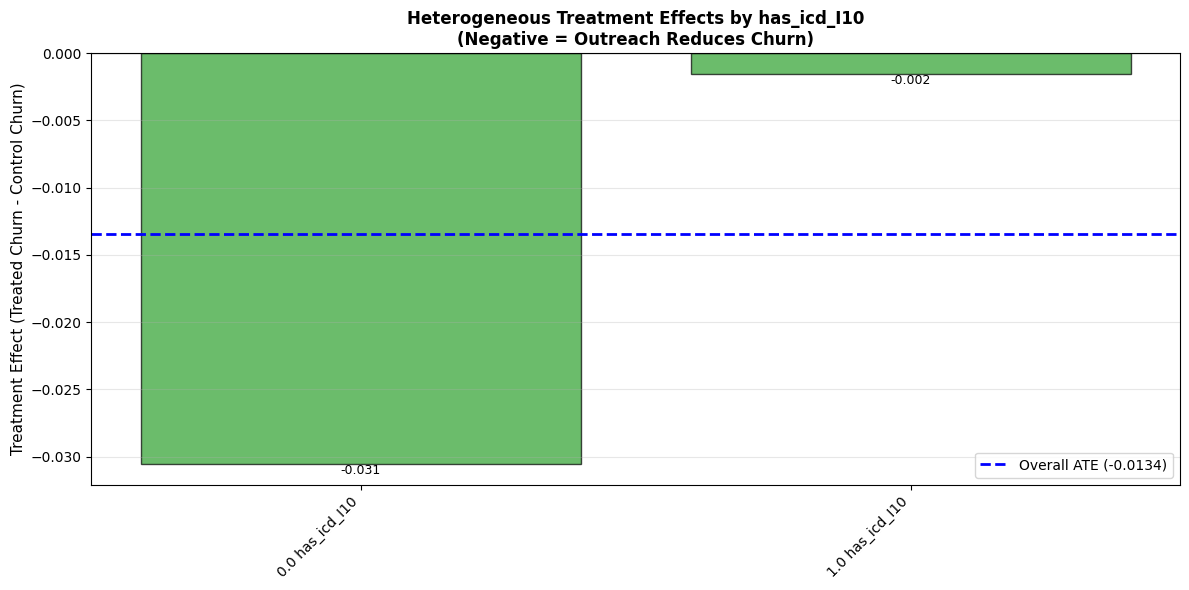


💡 CLINICAL INSIGHT for has_icd_I10:
   ✅ BEST: 0.0 has_icd_I10 shows strongest benefit (ATE=-0.0306)
      → Prioritize outreach for this segment (4113 members)

TREATMENT EFFECT BY HAS_ICD_E11_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_E11_9 -0.024911     4120       1652       2468       0.197942       0.222853
1.0 has_icd_E11_9 -0.005478     5880       2332       3548       0.191252       0.196731

Overall ATE (reference): -0.0134


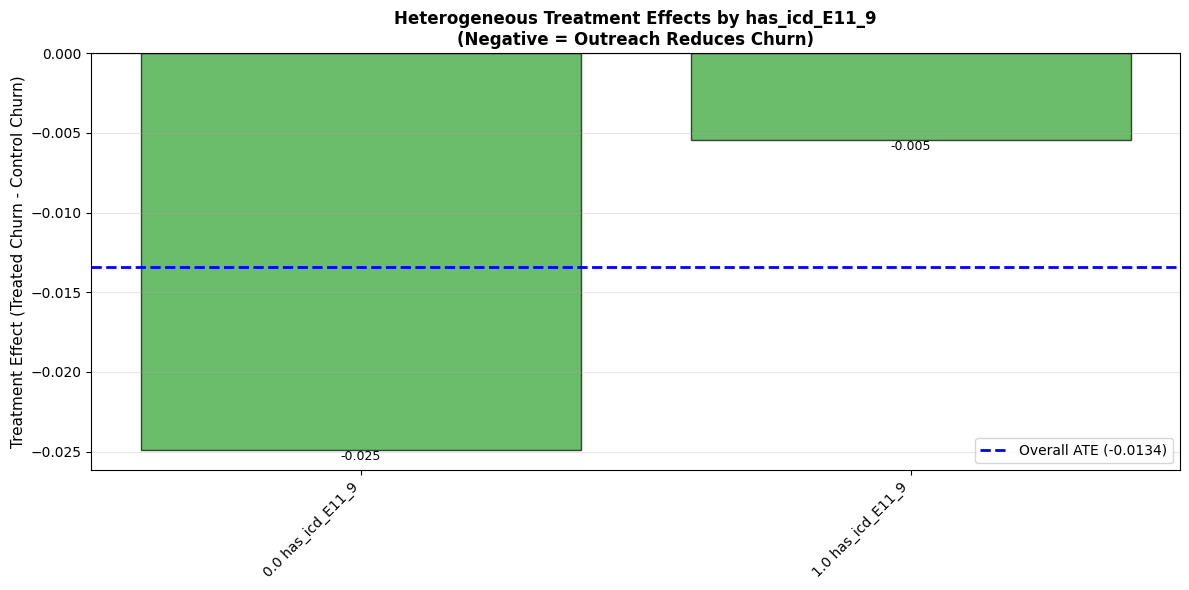


💡 CLINICAL INSIGHT for has_icd_E11_9:
   ✅ BEST: 0.0 has_icd_E11_9 shows strongest benefit (ATE=-0.0249)
      → Prioritize outreach for this segment (4120 members)

TREATMENT EFFECT BY HAS_ICD_K21_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_K21_9 -0.005015     5938       2390       3548       0.197071       0.202086
1.0 has_icd_K21_9 -0.025693     4062       1594       2468       0.189460       0.215154

Overall ATE (reference): -0.0134


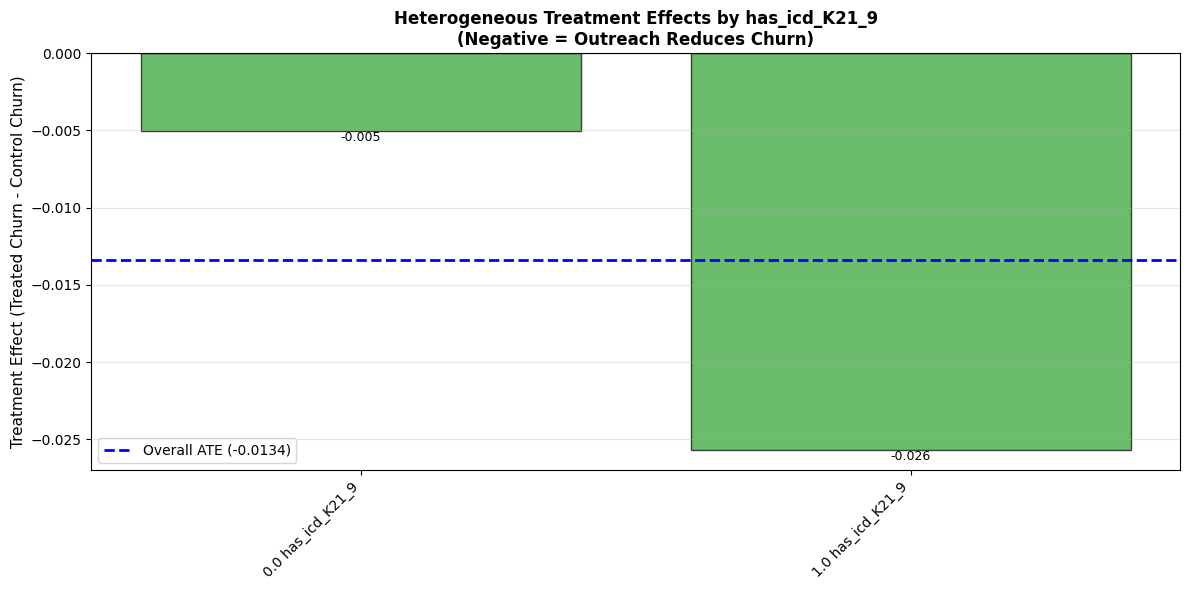


💡 CLINICAL INSIGHT for has_icd_K21_9:
   ✅ BEST: 1.0 has_icd_K21_9 shows strongest benefit (ATE=-0.0257)
      → Prioritize outreach for this segment (4062 members)

TREATMENT EFFECT BY HAS_ICD_R51 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_R51 -0.023992     5957       2373       3584       0.184155       0.208147
1.0 has_icd_R51  0.002152     4043       1611       2432       0.208566       0.206414

Overall ATE (reference): -0.0134


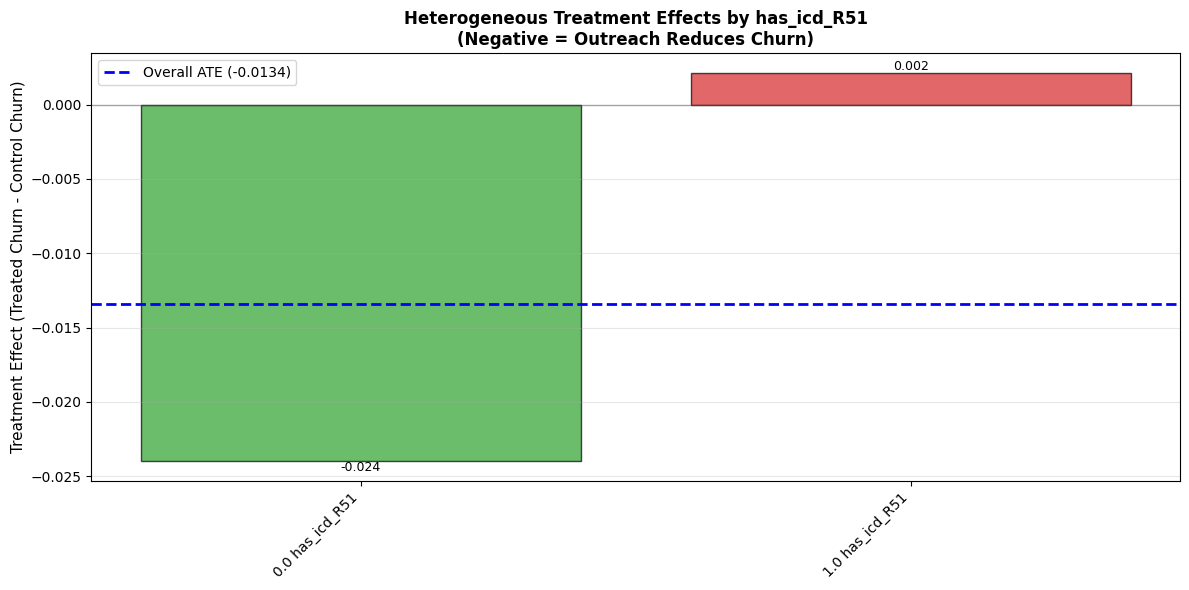


💡 CLINICAL INSIGHT for has_icd_R51:
   ✅ BEST: 0.0 has_icd_R51 shows strongest benefit (ATE=-0.0240)
      → Prioritize outreach for this segment (5957 members)
   ⚠️  WORST: 1.0 has_icd_R51 shows harm/no benefit (ATE=0.0022)
      → Avoid outreach for this segment (4043 members)

TREATMENT EFFECT BY HAS_ICD_A09 LEVEL
        Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_A09 -0.027053     5861       2289       3572       0.179554       0.206607
1.0 has_icd_A09  0.004895     4139       1695       2444       0.213569       0.208674

Overall ATE (reference): -0.0134


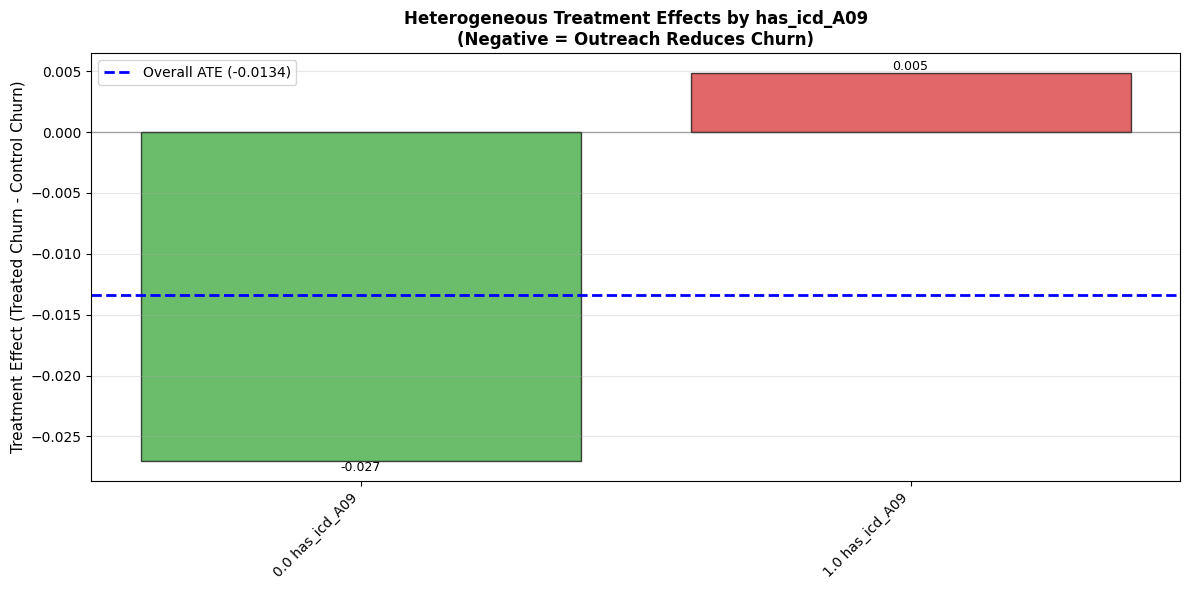


💡 CLINICAL INSIGHT for has_icd_A09:
   ✅ BEST: 0.0 has_icd_A09 shows strongest benefit (ATE=-0.0271)
      → Prioritize outreach for this segment (5861 members)
   ⚠️  WORST: 1.0 has_icd_A09 shows harm/no benefit (ATE=0.0049)
      → Avoid outreach for this segment (4139 members)

TREATMENT EFFECT BY HAS_ICD_B34_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_B34_9 -0.008176     5798       2330       3468       0.198283       0.206459
1.0 has_icd_B34_9 -0.020762     4202       1654       2548       0.188029       0.208791

Overall ATE (reference): -0.0134


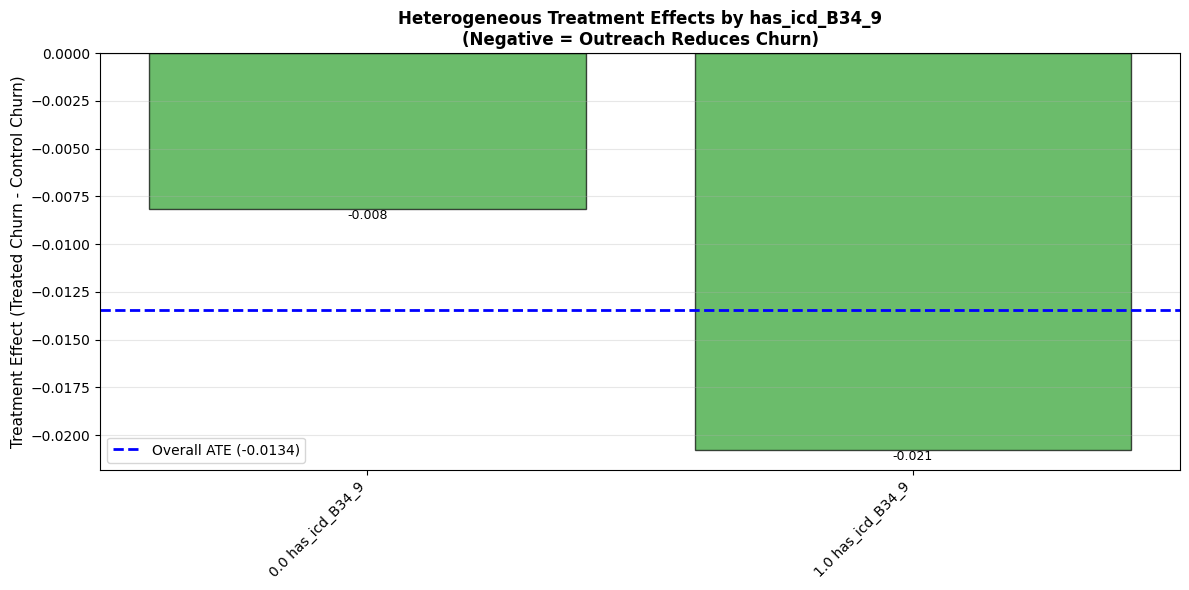


💡 CLINICAL INSIGHT for has_icd_B34_9:
   ✅ BEST: 1.0 has_icd_B34_9 shows strongest benefit (ATE=-0.0208)
      → Prioritize outreach for this segment (4202 members)

TREATMENT EFFECT BY HAS_ICD_H10_9 LEVEL
          Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
0.0 has_icd_H10_9 -0.021668     5841       2305       3536       0.189588       0.211256
1.0 has_icd_H10_9 -0.001897     4159       1679       2480       0.200119       0.202016

Overall ATE (reference): -0.0134


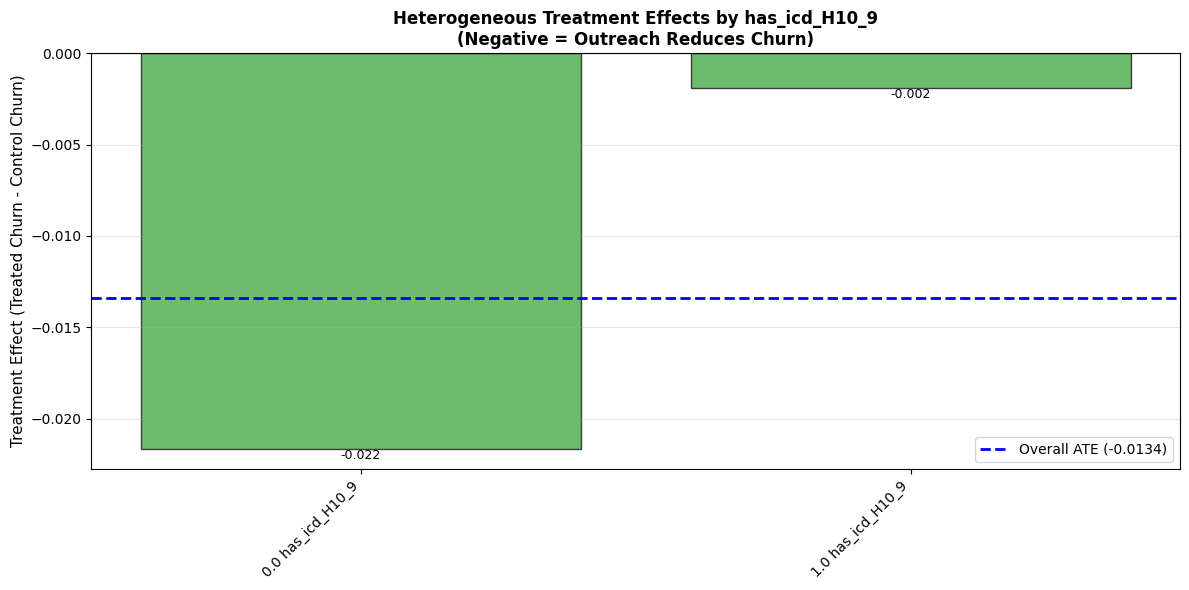


💡 CLINICAL INSIGHT for has_icd_H10_9:
   ✅ BEST: 0.0 has_icd_H10_9 shows strongest benefit (ATE=-0.0217)
      → Prioritize outreach for this segment (5841 members)

TREATMENT EFFECT BY EARLY_CLAIMS LEVEL
            Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low early_claims -0.014098     3705       1442       2263       0.205964       0.220062
Medium early_claims -0.028793     4027       1625       2402       0.173538       0.202331
  High early_claims  0.016149     2268        917       1351       0.211559       0.195411

Overall ATE (reference): -0.0134


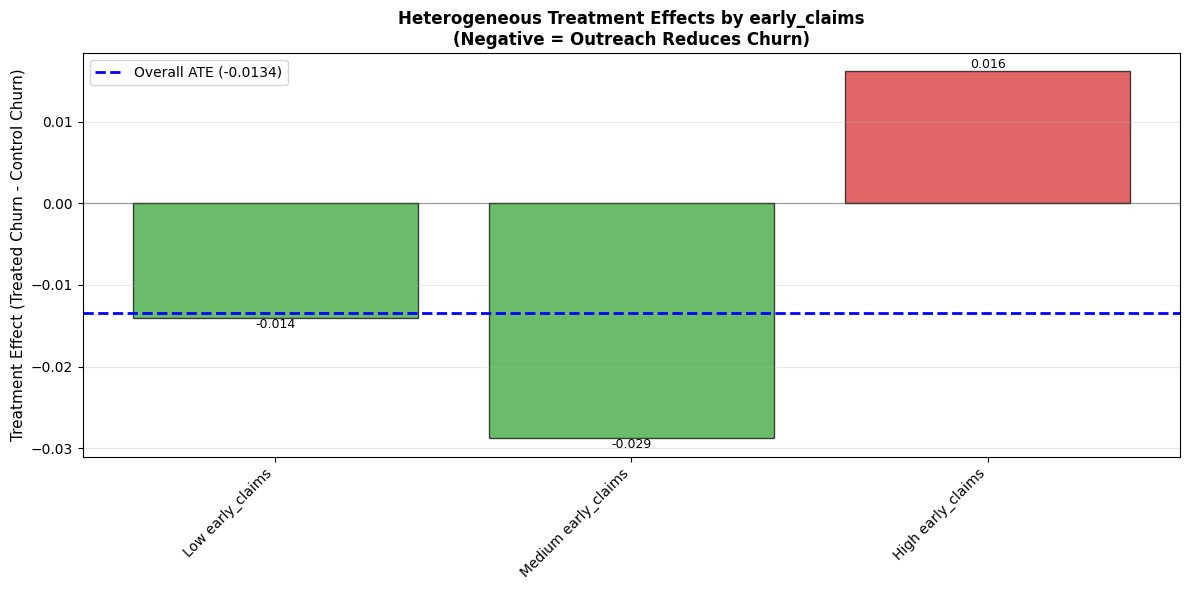


💡 CLINICAL INSIGHT for early_claims:
   ✅ BEST: Medium early_claims shows strongest benefit (ATE=-0.0288)
      → Prioritize outreach for this segment (4027 members)
   ⚠️  WORST: High early_claims shows harm/no benefit (ATE=0.0161)
      → Avoid outreach for this segment (2268 members)

TREATMENT EFFECT BY LATE_CLAIMS LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low late_claims -0.017909     3798       1512       2286       0.197751       0.215661
Medium late_claims -0.023049     3906       1545       2361       0.185761       0.208810
  High late_claims  0.010345     2296        927       1369       0.201726       0.191381

Overall ATE (reference): -0.0134


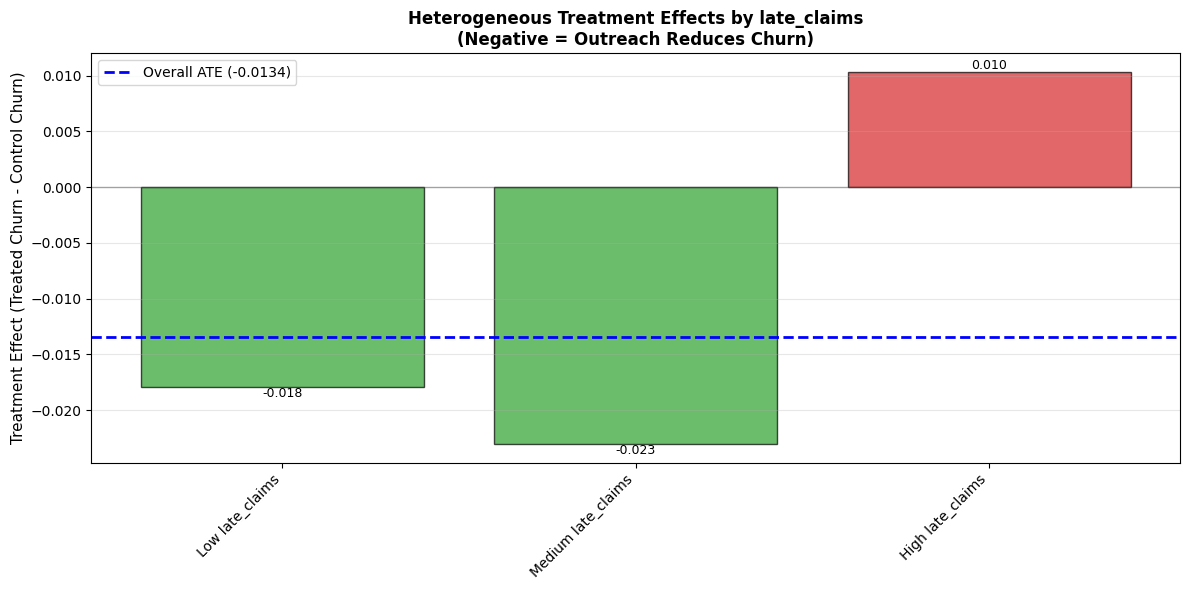


💡 CLINICAL INSIGHT for late_claims:
   ✅ BEST: Medium late_claims shows strongest benefit (ATE=-0.0230)
      → Prioritize outreach for this segment (3906 members)
   ⚠️  WORST: High late_claims shows harm/no benefit (ATE=0.0103)
      → Avoid outreach for this segment (2296 members)

TREATMENT EFFECT BY CLAIM_TREND LEVEL
           Segment       ATE  Members  N_Treated  N_Control  Treated_Churn  Control_Churn
   Low claim_trend -0.019338     4220       1691       2529       0.187463       0.206801
Medium claim_trend -0.010138     3038       1219       1819       0.204266       0.214404
  High claim_trend -0.008102     2742       1074       1668       0.192737       0.200839

Overall ATE (reference): -0.0134


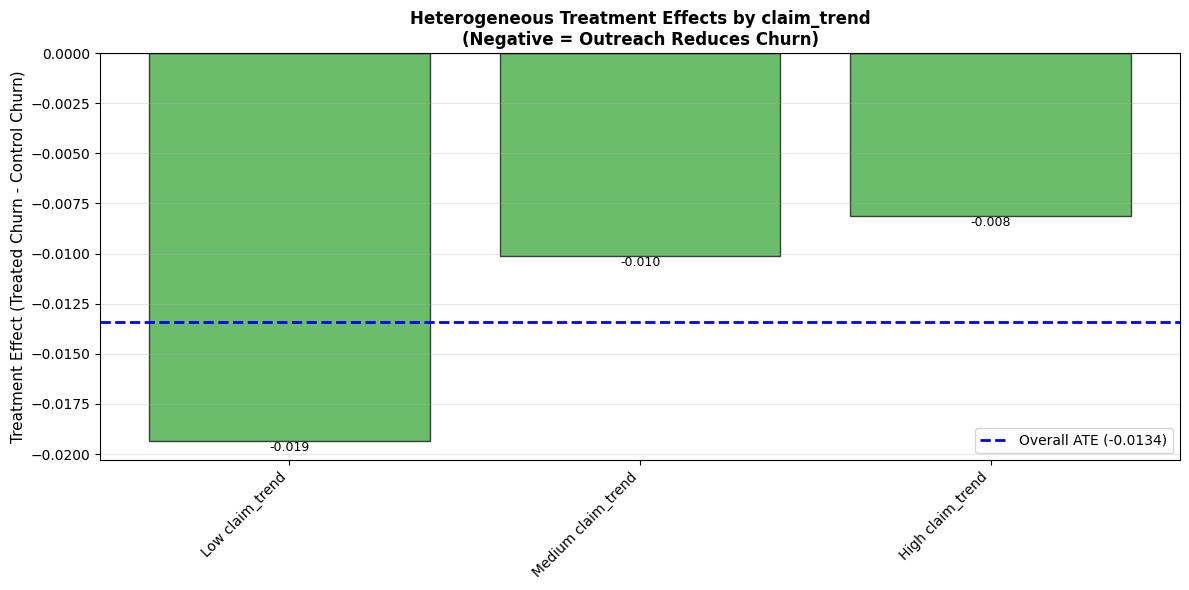


💡 CLINICAL INSIGHT for claim_trend:
   ✅ BEST: Low claim_trend shows strongest benefit (ATE=-0.0193)
      → Prioritize outreach for this segment (4220 members)

SUMMARY: Use these insights to target outreach based on uplift model predictions


In [33]:
## Analyze Heterogeneous Treatment Effects by Segment


# Prepare data with labels
X_train_with_labels = X_train.copy()
X_train_with_labels["churn"] = y_train.values
X_train_with_labels["outreach"] = treatment_train.values

# Calculate overall ATE for reference
overall_ate = (
    y_train[treatment_train == 1].mean() - y_train[treatment_train == 0].mean()
)

# Features to analyze (WellCo clinical priorities)
features_ate = X_train.columns.tolist()

for feature in features_ate:
    if feature not in X_train.columns:
        print(f"\n⚠️  Feature '{feature}' not found in X_train, skipping...")
        continue

    # Check if feature has variation
    if X_train[feature].nunique() <= 1:
        print(f"\n⚠️  Feature '{feature}' has no variation, skipping...")
        continue

    # Handle features with few unique values (binary/categorical)
    unique_vals = X_train[feature].nunique()

    try:
        if unique_vals <= 3:
            # For binary/low-cardinality features, use actual values as segments
            X_train_with_labels[f"{feature}_level"] = X_train[feature].astype(str)
            segments = sorted(X_train_with_labels[f"{feature}_level"].unique())
        else:
            # For continuous features, create tertiles
            X_train_with_labels[f"{feature}_level"] = pd.qcut(
                X_train[feature],
                q=3,
                labels=["Low", "Medium", "High"],
                duplicates="drop",  # Handle tied values
            )
            segments = ["Low", "Medium", "High"]

        # Calculate ATE for each segment
        segment_ates = []
        for segment in segments:
            mask = X_train_with_labels[f"{feature}_level"] == segment

            # Check if we have both treated and control members in this segment
            n_treated = (mask & (treatment_train == 1)).sum()
            n_control = (mask & (treatment_train == 0)).sum()

            if n_treated == 0 or n_control == 0:
                print(
                    f"\n⚠️  Segment '{segment}' has no treated or control members, skipping..."
                )
                continue

            treated_churn = X_train_with_labels.loc[
                mask & (treatment_train == 1), "churn"
            ].mean()
            control_churn = X_train_with_labels.loc[
                mask & (treatment_train == 0), "churn"
            ].mean()

            segment_ate = treated_churn - control_churn
            n_members = mask.sum()

            segment_ates.append(
                {
                    "Segment": f"{segment} {feature}",
                    "ATE": segment_ate,
                    "Members": n_members,
                    "N_Treated": n_treated,
                    "N_Control": n_control,
                    "Treated_Churn": treated_churn,
                    "Control_Churn": control_churn,
                }
            )

        if len(segment_ates) == 0:
            print(f"\n⚠️  No valid segments for '{feature}', skipping...")
            continue

        ate_df = pd.DataFrame(segment_ates)

        # Print results
        print("\n" + "=" * 80)
        print(f"TREATMENT EFFECT BY {feature.upper()} LEVEL")
        print("=" * 80)
        print(ate_df.to_string(index=False))
        print(f"\nOverall ATE (reference): {overall_ate:.4f}")
        print("=" * 80)

        # Visualize
        fig, ax = plt.subplots(figsize=(12, 6))
        x = range(len(ate_df))
        colors = ["#d62728" if ate > 0 else "#2ca02c" for ate in ate_df["ATE"]]

        bars = ax.bar(x, ate_df["ATE"], color=colors, alpha=0.7, edgecolor="black")

        # Add value labels on bars
        for i, (idx, row) in enumerate(ate_df.iterrows()):
            ax.text(
                i,
                row["ATE"],
                f'{row["ATE"]:.3f}',
                ha="center",
                va="bottom" if row["ATE"] > 0 else "top",
                fontsize=9,
            )

        # Reference lines
        ax.axhline(y=0, color="black", linestyle="-", linewidth=1, alpha=0.3)
        ax.axhline(
            y=overall_ate,
            color="blue",
            linestyle="--",
            linewidth=2,
            label=f"Overall ATE ({overall_ate:.4f})",
        )

        ax.set_xticks(x)
        ax.set_xticklabels(ate_df["Segment"], rotation=45, ha="right")
        ax.set_ylabel("Treatment Effect (Treated Churn - Control Churn)", fontsize=11)
        ax.set_title(
            f"Heterogeneous Treatment Effects by {feature}\n(Negative = Outreach Reduces Churn)",
            fontsize=12,
            fontweight="bold",
        )
        ax.legend(loc="best")
        ax.grid(axis="y", alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Clinical interpretation for WellCo
        print(f"\n💡 CLINICAL INSIGHT for {feature}:")
        best_segment = ate_df.loc[ate_df["ATE"].idxmin()]
        worst_segment = ate_df.loc[ate_df["ATE"].idxmax()]

        if best_segment["ATE"] < overall_ate:
            print(
                f"   ✅ BEST: {best_segment['Segment']} shows strongest benefit (ATE={best_segment['ATE']:.4f})"
            )
            print(
                f"      → Prioritize outreach for this segment ({best_segment['Members']} members)"
            )

        if worst_segment["ATE"] > 0:
            print(
                f"   ⚠️  WORST: {worst_segment['Segment']} shows harm/no benefit (ATE={worst_segment['ATE']:.4f})"
            )
            print(
                f"      → Avoid outreach for this segment ({worst_segment['Members']} members)"
            )

    except Exception as e:
        print(f"\n❌ Error processing '{feature}': {str(e)}")
        continue

print("\n" + "=" * 80)
print(
    "SUMMARY: Use these insights to target outreach based on uplift model predictions"
)
print("=" * 80)

## training

### maunal t learn

Qini AUC (area over random): -160269.4730
Normalized Qini AUC: -1.7927


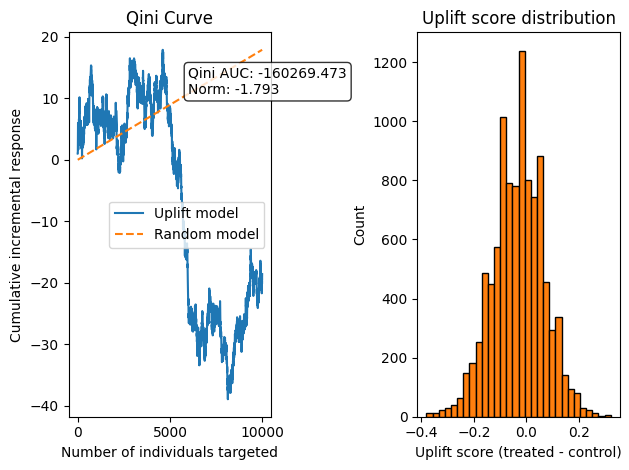

In [34]:


# ---------------------------
#  dataset
# ---------------------------
X = X_train
treatment = treatment_train
y = y_train
# ---------------------------
# 1. Propensity score estimation
# ---------------------------
prop_model = LogisticRegression(max_iter=1000)
prop_model.fit(X, treatment)
propensity_scores = prop_model.predict_proba(X)[:, 1]

# ---------------------------
# 2. Train separate outcome models (T-learner)
# ---------------------------
weights_treated = 1 / propensity_scores
weights_control = 1 / (1 - propensity_scores)

model_treated = RandomForestClassifier(n_estimators=100, random_state=42)
model_treated.fit(
    X[treatment == 1], y[treatment == 1], sample_weight=weights_treated[treatment == 1]
)

model_control = RandomForestClassifier(n_estimators=100, random_state=42)
model_control.fit(
    X[treatment == 0], y[treatment == 0], sample_weight=weights_control[treatment == 0]
)

# ---------------------------
# 3. Predict outcomes under treatment and control
# ---------------------------
y_pred_treated = model_treated.predict_proba(X_test)[:, 1]
y_pred_control = model_control.predict_proba(X_test)[:, 1]

uplift_scores = y_pred_treated - y_pred_control


# ---------------------------
# 4. Qini curve
# ---------------------------
def qini_curve(y, treatment, uplift):
    """Compute Qini curve points"""
    df = pd.DataFrame({"y": y, "t": treatment, "uplift": uplift})
    df = df.sort_values("uplift", ascending=False)

    cum_treated = df["t"].cumsum()
    cum_control = (~df["t"].astype(bool)).cumsum()

    cum_outcome_treated = (df["y"] * df["t"]).cumsum()
    cum_outcome_control = (df["y"] * (1 - df["t"])).cumsum()

    # Qini: difference in cumulative outcomes scaled by group sizes
    qini = cum_outcome_treated - cum_outcome_control * (
        cum_treated / np.maximum(cum_control, 1)
    )
    return qini


qini = qini_curve(y_test, treatment_test, uplift_scores)


# Qini curve subplot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(qini) + 1), qini, label="Uplift model")
plt.plot([0, len(qini)], [0, qini.max()], "--", label="Random model")
plt.xlabel("Number of individuals targeted")
plt.ylabel("Cumulative incremental response")
plt.title("Qini Curve")
plt.legend()

# compute Qini AUC (area between model qini curve and random model)
x = np.arange(1, len(qini) + 1)
qini_vals = qini.values

model_auc = np.trapz(qini_vals, x)
random_line = np.linspace(0, qini_vals.max(), len(qini_vals))
random_auc = np.trapz(random_line, x)

qini_auc = model_auc - random_auc
qini_auc_norm = qini_auc / random_auc if random_auc != 0 else np.nan

print(f"Qini AUC (area over random): {qini_auc:.4f}")
print(f"Normalized Qini AUC: {qini_auc_norm:.4f}")

# annotate qini plot
plt.subplot(1, 2, 1)
plt.annotate(
    f"Qini AUC: {qini_auc:.3f}\nNorm: {qini_auc_norm:.3f}",
    xy=(0.6 * len(qini_vals), 0.6 * qini_vals.max()),
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8),
)

# second subplot: uplift score distribution for diagnostics
plt.subplot(1, 2, 2)
plt.hist(uplift_scores, bins=30, color="C1", edgecolor="k")
plt.xlabel("Uplift score (treated - control)")
plt.ylabel("Count")
plt.title("Uplift score distribution")
plt.tight_layout()
plt.show()

### s learner

In [35]:
## Elastic Net Logistic Regression

logistic_elasticnet = LogisticRegression(
    random_state=42,
    max_iter=5000,
    class_weight="balanced",
    penalty="elasticnet",  # Mix of L1 and L2
    solver="saga",
    C=0.2,
    l1_ratio=0.1,  # 0.5 = equal mix of L1 and L2
)

slearner_logistic_enet = SoloModel(estimator=logistic_elasticnet)
slearner_logistic_enet.fit(X_train, y_train, treatment=treatment_train)

uplift_test_enet = slearner_logistic_enet.predict(X_test)
test_qini_enet = qini_auc_score(y_test, uplift_test_enet, treatment_test)
print(f"Elastic Net Logistic Test Qini AUC: {test_qini_enet:.4f}")
uplift_train_enet = slearner_logistic_enet.predict(X_train)
train_qini_enet = qini_auc_score(y_train, uplift_train_enet, treatment_train)
print(f"Elastic Net Logistic Train Qini AUC: {train_qini_enet:.4f}")

Elastic Net Logistic Test Qini AUC: 0.0508
Elastic Net Logistic Train Qini AUC: 0.0223


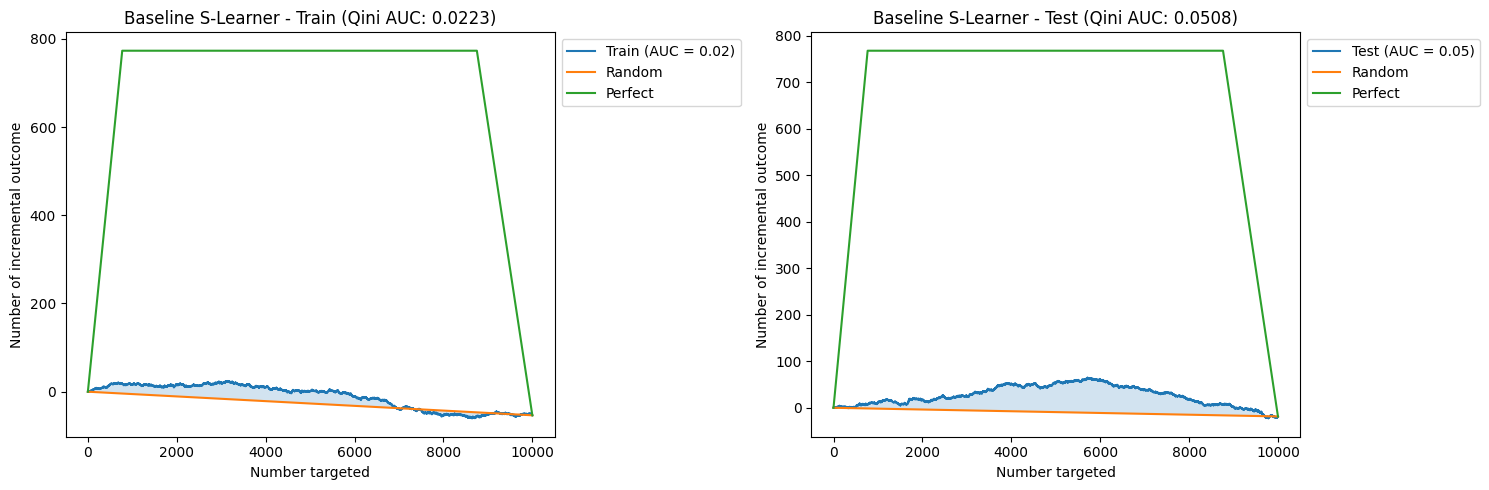


Model: Baseline S-Learner
Train Qini AUC: 0.0223
Test Qini AUC:  0.0508
Overfitting Gap: -0.0285 (-127.8% relative)
✅ Good generalization



(0.02228616800623734, 0.050766493737781665, -0.028480325731544326)

In [36]:
compare_train_test_performance(
    slearner_logistic_enet,
    X_train,
    X_test,
    y_train,
    y_test,
    treatment_train,
    treatment_test,
    model_name="Baseline S-Learner",
)


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.044921
  Max: -0.018577
  Range: 0.026345
  Mean: -0.042287
  Std: 0.003353

⚠️  ISSUE: Very narrow uplift range (0.026345)
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


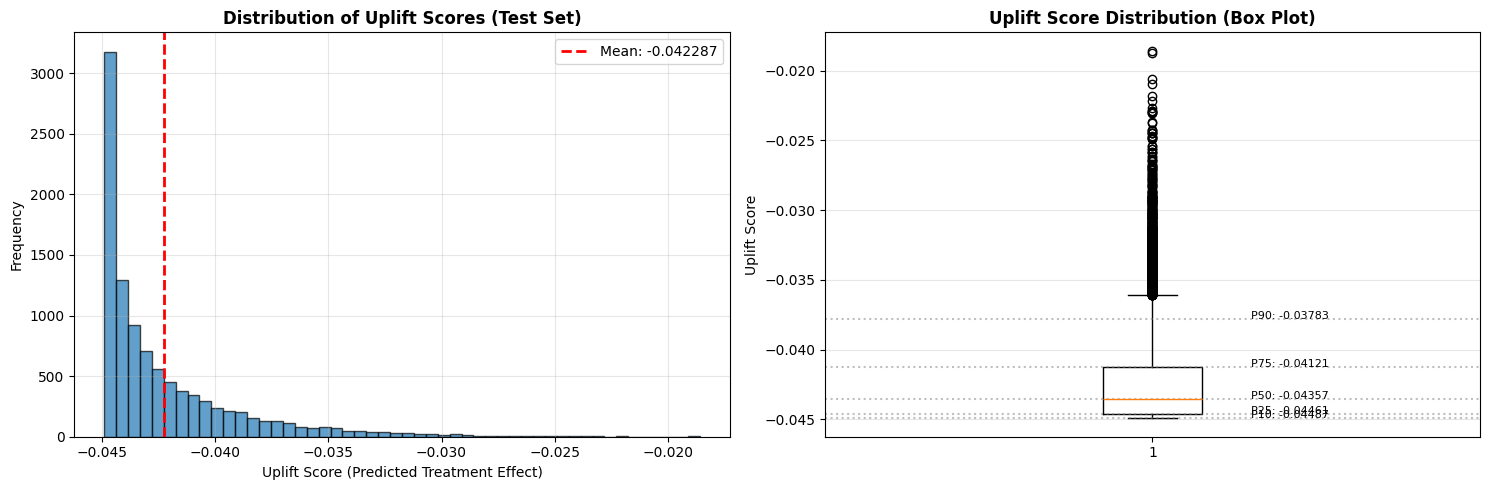


✅ Distribution plot saved to: outputs/uplift_distribution_20251116T220142Z.png


In [37]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {uplift_test_enet.min():.6f}")
print(f"  Max: {uplift_test_enet.max():.6f}")
print(f"  Range: {uplift_test_enet.max() - uplift_test_enet.min():.6f}")
print(f"  Mean: {uplift_test_enet.mean():.6f}")
print(f"  Std: {uplift_test_enet.std():.6f}")

print(
    f"\n⚠️  ISSUE: Very narrow uplift range ({uplift_test_enet.max() - uplift_test_enet.min():.6f})"
)
print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(uplift_test_enet, bins=50, edgecolor="black", alpha=0.7)
ax1.axvline(
    uplift_test_enet.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {uplift_test_enet.mean():.6f}",
)
ax1.set_xlabel("Uplift Score (Predicted Treatment Effect)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Uplift Scores (Test Set)", fontweight="bold")
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot with percentiles
ax2.boxplot(uplift_test_enet, vert=True)
ax2.set_ylabel("Uplift Score")
ax2.set_title("Uplift Score Distribution (Box Plot)", fontweight="bold")
ax2.grid(alpha=0.3, axis="y")

# Add percentile annotations
percentiles = [10, 25, 50, 75, 90]
for p in percentiles:
    val = np.percentile(uplift_test_enet, p)
    ax2.axhline(val, color="gray", linestyle=":", alpha=0.5)
    ax2.text(1.15, val, f"P{p}: {val:.5f}", fontsize=8)

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"uplift_distribution_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(f"\n✅ Distribution plot saved to: outputs/uplift_distribution_{timestamp}.png")
print("=" * 80)

### DRLearner

Training DRLearner on training set...


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l


Top 5 Ranked Members (Test Set):
   member_id  prioritization_score  rank
0       6284             -0.690073     1
1        468             -0.626352     2
2       3967             -0.619847     3
3       2114             -0.608939     4
4       9758             -0.607898     5

--- Uplift Model Metrics (Test Set) ---
Total Theoretical Uplift Gain: 18.5822
Area Under the Uplift Curve (AUUC, Normalized): 9.886733
--- Uplift Model Metrics (Test Set) ---


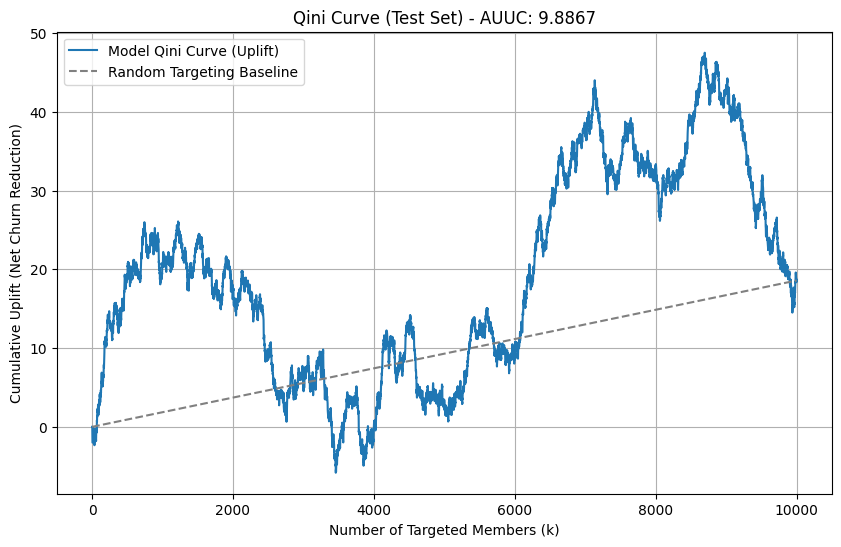

In [38]:


# ----------------------------------------------------------------------
# 1. Data Loading and Preparation
df_test = pd.DataFrame(
    {
        "churn": y_test,
        "outreach": treatment_test,
        "member_id": np.arange(10000),  # Placeholder member IDs
    }
)
# -------------------------------------------------

# ----------------------------------------------------------------------
# 2. EconML Model Training (DRLearner) - Corrected
# ----------------------------------------------------------------------

# Define the models
model_propensity = LogisticRegression(solver="lbfgs")  # P(T|X)
# IMPORTANT: Added model_regression for E[Y|X, T], using Regressor for continuous Y
model_regression = RandomForestRegressor(
    n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42
)
model_final = GradientBoostingRegressor(
    n_estimators=100, max_depth=3, min_samples_leaf=10, random_state=42
)  # Final CATE Estimator (tau(X))

# DRLearner model instance - Using correct parameters: model_propensity and model_regression
dr_learner = DRLearner(
    model_final=model_final,
    model_propensity=model_propensity,  # Corrected from 'model_t'
    model_regression=model_regression,  # Added for complete doubly robust estimation
    cv=5,
    mc_iters=3,
    random_state=42,
)

print("Training DRLearner on training set...")
# Fit the model using the training data
dr_learner.fit(
    Y=y_train,
    T=treatment_train,
    X=X_train,
    W=None,  # Assuming no features W that only affect the outcome, not the treatment effect
)

# ----------------------------------------------------------------------
# 3. CATE Prediction (Uplift Score) - Using Test Data
# ----------------------------------------------------------------------

# Predict CATE on the held-out TEST set
uplift_test_dr = dr_learner.effect(X_test)
test_qini_dr = qini_auc_score(y_test, uplift_test_dr, treatment_test)
uplift_train_dr = dr_learner.effect(X_train)
train_qini_dr = qini_auc_score(y_train, uplift_train_dr, treatment_train)


# Add results to the test DataFrame
df_results_test = df_test.copy()
df_results_test["prioritization_score"] = uplift_test_dr

# Sort and Rank the test members
df_results_test = df_results_test.sort_values(
    by="prioritization_score", ascending=True
).reset_index(drop=True)
df_results_test["rank"] = df_results_test.index + 1

# Output the required ranked list
top_n_members_test = df_results_test[["member_id", "prioritization_score", "rank"]]
print("\nTop 5 Ranked Members (Test Set):")
print(top_n_members_test.head())
top_n_members_test.to_csv("ranked_members_for_outreach_test.csv", index=False)

# ----------------------------------------------------------------------
# 4. Qini/AUUC Calculation and Plotting (Using Test Data)
# ----------------------------------------------------------------------



# Calculate and plot the results
df_qini_test, auuc_score_test, total_uplift_gain_test = calculate_qini_auuc(
    df_results_test
)

# Plotting the Qini Curve
plt.figure(figsize=(10, 6))
plt.plot(
    df_qini_test["k"], df_qini_test["qini_gain"], label="Model Qini Curve (Uplift)"
)
plt.plot(
    df_qini_test["k"],
    df_qini_test["random_gain"],
    linestyle="--",
    color="gray",
    label="Random Targeting Baseline",
)

plt.title(f"Qini Curve (Test Set) - AUUC: {auuc_score_test:.4f}")
plt.xlabel("Number of Targeted Members (k)")
plt.ylabel("Cumulative Uplift (Net Churn Reduction)")
plt.legend()
plt.grid(True)
plt.savefig("qini_curve_test.png")
print(f"\n--- Uplift Model Metrics (Test Set) ---")
print(f"Total Theoretical Uplift Gain: {total_uplift_gain_test:.4f}")
print(f"Area Under the Uplift Curve (AUUC, Normalized): {auuc_score_test:.6f}")
print("--- Uplift Model Metrics (Test Set) ---")


UPLIFT SCORE VARIANCE DIAGNOSTICS

Uplift score range:
  Min: -0.690073
  Max: 0.479807
  Range: 1.169879
  Mean: -0.037005
  Std: 0.077739
   This indicates weak heterogeneous treatment effects
   Model predicts similar uplift for most members


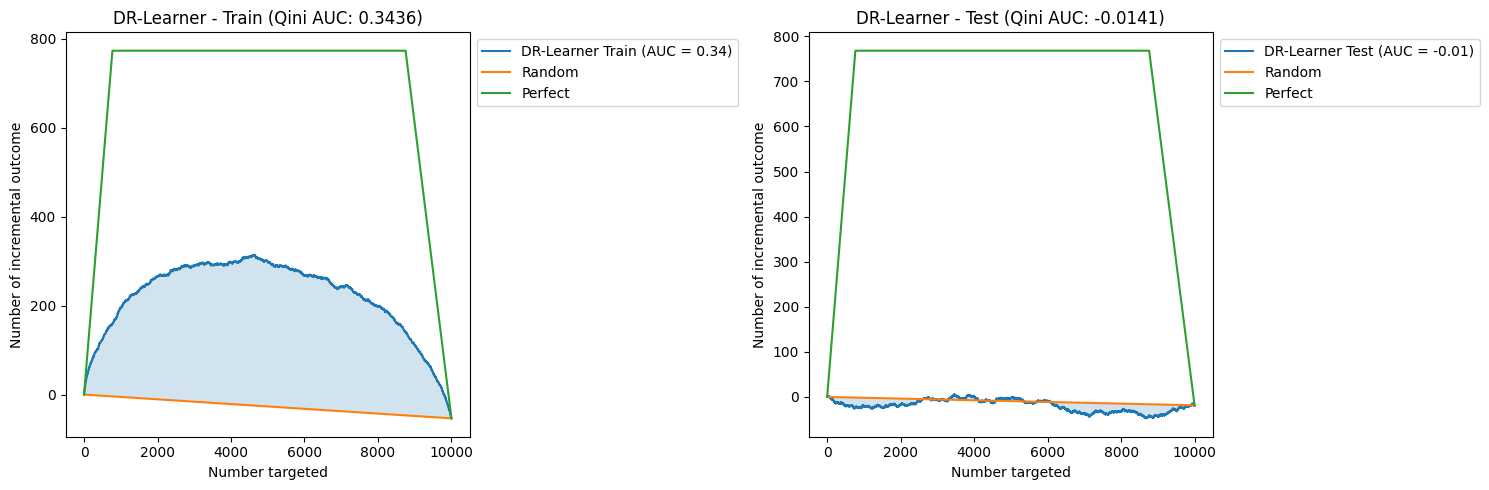

In [39]:
## Uplift Score Variance Analysis

print("\n" + "=" * 80)
print("UPLIFT SCORE VARIANCE DIAGNOSTICS")
print("=" * 80)

print(f"\nUplift score range:")
print(f"  Min: {uplift_test_dr.min():.6f}")
print(f"  Max: {uplift_test_dr.max():.6f}")
print(f"  Range: {uplift_test_dr.max() - uplift_test_dr.min():.6f}")
print(f"  Mean: {uplift_test_dr.mean():.6f}")
print(f"  Std: {uplift_test_dr.std():.6f}")

print(f"   This indicates weak heterogeneous treatment effects")
print(f"   Model predicts similar uplift for most members")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_dr,
    treatment_train,
    perfect=True,
    name="DR-Learner Train",
    ax=ax1,
)
ax1.set_title(f"DR-Learner - Train (Qini AUC: {train_qini_dr:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_dr,
    treatment_test,
    perfect=True,
    name="DR-Learner Test",
    ax=ax2,
)
ax2.set_title(f"DR-Learner - Test (Qini AUC: {test_qini_dr:.4f})")
plt.tight_layout()
plt.show()

### t learner

[LightGBM] [Info] Number of positive: 1248, number of negative: 4768
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 6016, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.207447 -> initscore=-1.340385
[LightGBM] [Info] Start training from score -1.340385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

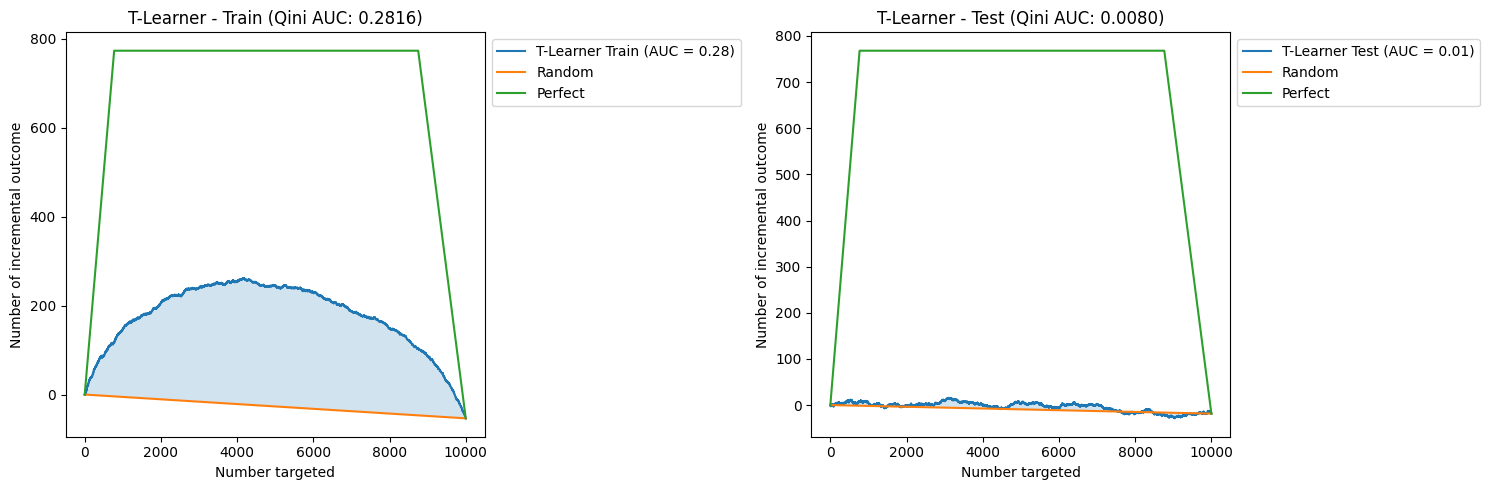

In [40]:
from sklift.models import TwoModels

# Create SEPARATE instances for treatment and control to avoid sklearn error
lgbm_t_treatment = LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    n_estimators=100,  # Reduced from 300
    max_depth=3,  # Shallow trees to prevent overfitting
    learning_rate=0.1,  # Increased from 0.03
    min_child_samples=100,  # Increased from 30
    reg_alpha=0.5,  # Strong L1 regularization
    reg_lambda=0.5,  # Strong L2 regularization
    min_split_gain=0.1,  # Require minimum gain to split
    subsample=0.7,  # Bagging
    colsample_bytree=0.7,  # Feature sampling
)

lgbm_t_control = LGBMClassifier(
    random_state=43,  # Different seed
    n_jobs=-1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    min_child_samples=100,
    reg_alpha=10.0,
    reg_lambda=5.0,
    min_split_gain=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
)

tlearner = TwoModels(
    estimator_trmnt=lgbm_t_treatment, estimator_ctrl=lgbm_t_control, method="vanilla"
)

tlearner.fit(X_train, y_train, treatment=treatment_train)

# Evaluate
uplift_train_tlearner = tlearner.predict(X_train)
uplift_test_tlearner = tlearner.predict(X_test)

train_qini_tlearner = qini_auc_score(y_train, uplift_train_tlearner, treatment_train)
test_qini_tlearner = qini_auc_score(y_test, uplift_test_tlearner, treatment_test)

print("\n" + "=" * 70)
print("T-LEARNER (REGULARIZED) WITH LIGHTGBM")
print("=" * 70)
print(f"Train Qini AUC: {train_qini_tlearner:.4f}")
print(f"Test Qini AUC:  {test_qini_tlearner:.4f}")
print(f"Overfitting Gap: {train_qini_tlearner - test_qini_tlearner:.4f}")
print("=" * 70)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_tlearner,
    treatment_train,
    perfect=True,
    name="T-Learner Train",
    ax=ax1,
)
ax1.set_title(f"T-Learner - Train (Qini AUC: {train_qini_tlearner:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_tlearner,
    treatment_test,
    perfect=True,
    name="T-Learner Test",
    ax=ax2,
)
ax2.set_title(f"T-Learner - Test (Qini AUC: {test_qini_tlearner:.4f})")
plt.tight_layout()
plt.show()

### X learner


X-LEARNER (ADVANCED META-LEARNER)

X-Learner steps:
  1. Train models on treatment/control groups (like T-Learner)
  2. Impute counterfactual outcomes
  3. Train models to predict treatment effects directly
  4. Weight by propensity scores

Training data split:
  Treatment group: 3984 samples
  Control group: 6016 samples

Imputed treatment effects:
  Treated group ITE mean: -0.034840
  Control group ITE mean: -0.039092

X-Learner Performance:
  Train Qini AUC: 0.0570
  Test Qini AUC:  -0.0063
  Overfitting Gap: 0.0633

Uplift score statistics (test):
  Range: 0.293837
  Mean: -0.036782
  Std: 0.034596


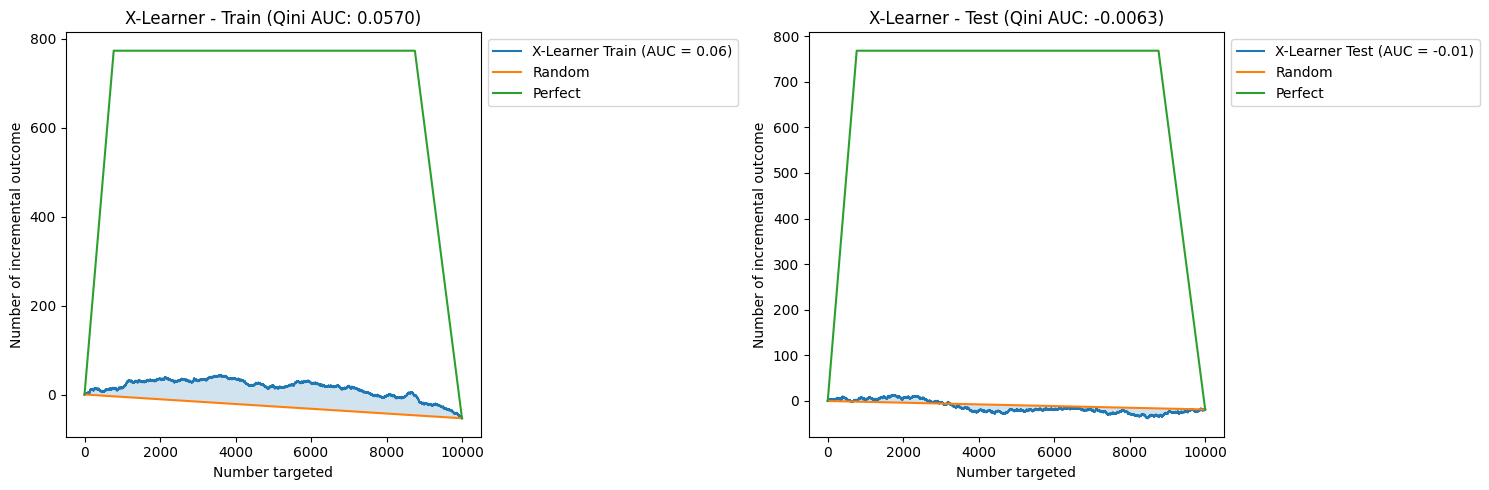

In [41]:
## Experiment 2: X-Learner Implementation

print("\n" + "=" * 80)
print("X-LEARNER (ADVANCED META-LEARNER)")
print("=" * 80)

print("\nX-Learner steps:")
print("  1. Train models on treatment/control groups (like T-Learner)")
print("  2. Impute counterfactual outcomes")
print("  3. Train models to predict treatment effects directly")
print("  4. Weight by propensity scores")

# Step 1: Train base models on treatment and control
from sklearn.linear_model import Ridge

# Models for stage 1
mu0_model = Ridge(alpha=10.0, random_state=42)  # Control group model
mu1_model = Ridge(alpha=10.0, random_state=43)  # Treatment group model

# Split by treatment
X_train_treated = X_train[treatment_train == 1]
y_train_treated = y_train[treatment_train == 1]
X_train_control = X_train[treatment_train == 0]
y_train_control = y_train[treatment_train == 0]

print(f"\nTraining data split:")
print(f"  Treatment group: {len(X_train_treated)} samples")
print(f"  Control group: {len(X_train_control)} samples")

# Fit stage 1 models
mu0_model.fit(X_train_control, y_train_control)
mu1_model.fit(X_train_treated, y_train_treated)

# Step 2: Impute counterfactuals
# For treated: D_1 = Y_1 - mu_0(X_1)
# For control: D_0 = mu_1(X_0) - Y_0

D1 = y_train_treated.values - mu0_model.predict(X_train_treated)  # Treated ITE
D0 = mu1_model.predict(X_train_control) - y_train_control.values  # Control ITE

print(f"\nImputed treatment effects:")
print(f"  Treated group ITE mean: {D1.mean():.6f}")
print(f"  Control group ITE mean: {D0.mean():.6f}")

# Step 3: Train models to predict treatment effects
tau0_model = Ridge(alpha=10.0, random_state=44)  # ITE model on control
tau1_model = Ridge(alpha=10.0, random_state=45)  # ITE model on treatment

tau0_model.fit(X_train_control, D0)
tau1_model.fit(X_train_treated, D1)

# Step 4: Predict with propensity weighting
# tau(x) = g(x) * tau_0(x) + (1 - g(x)) * tau_1(x)
# where g(x) is propensity score

if "propensity_score" in X_test.columns:
    propensity_test = X_test["propensity_score"].values
else:
    # Estimate propensity if not available
    from sklearn.linear_model import LogisticRegression

    prop_model = LogisticRegression(random_state=42, max_iter=1000)
    prop_model.fit(X_train, treatment_train)
    propensity_test = prop_model.predict_proba(X_test)[:, 1]

# Final X-Learner prediction
tau0_pred = tau0_model.predict(X_test)
tau1_pred = tau1_model.predict(X_test)

uplift_test_xlearner = propensity_test * tau0_pred + (1 - propensity_test) * tau1_pred

# Train set predictions
if "propensity_score" in X_train.columns:
    propensity_train = X_train["propensity_score"].values
else:
    propensity_train = prop_model.predict_proba(X_train)[:, 1]

tau0_pred_train = tau0_model.predict(X_train)
tau1_pred_train = tau1_model.predict(X_train)
uplift_train_xlearner = (
    propensity_train * tau0_pred_train + (1 - propensity_train) * tau1_pred_train
)

# Evaluate
train_qini_xlearner = qini_auc_score(y_train, uplift_train_xlearner, treatment_train)
test_qini_xlearner = qini_auc_score(y_test, uplift_test_xlearner, treatment_test)

print(f"\nX-Learner Performance:")
print(f"  Train Qini AUC: {train_qini_xlearner:.4f}")
print(f"  Test Qini AUC:  {test_qini_xlearner:.4f}")
print(f"  Overfitting Gap: {train_qini_xlearner - test_qini_xlearner:.4f}")
print(f"\nUplift score statistics (test):")
print(f"  Range: {uplift_test_xlearner.max() - uplift_test_xlearner.min():.6f}")
print(f"  Mean: {uplift_test_xlearner.mean():.6f}")
print(f"  Std: {uplift_test_xlearner.std():.6f}")
print("=" * 80)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_qini_curve(
    y_train,
    uplift_train_xlearner,
    treatment_train,
    perfect=True,
    name="X-Learner Train",
    ax=ax1,
)
ax1.set_title(f"X-Learner - Train (Qini AUC: {train_qini_xlearner:.4f})")
plot_qini_curve(
    y_test,
    uplift_test_xlearner,
    treatment_test,
    perfect=True,
    name="X-Learner Test",
    ax=ax2,
)
ax2.set_title(f"X-Learner - Test (Qini AUC: {test_qini_xlearner:.4f})")
plt.tight_layout()
plt.show()

## models comparison

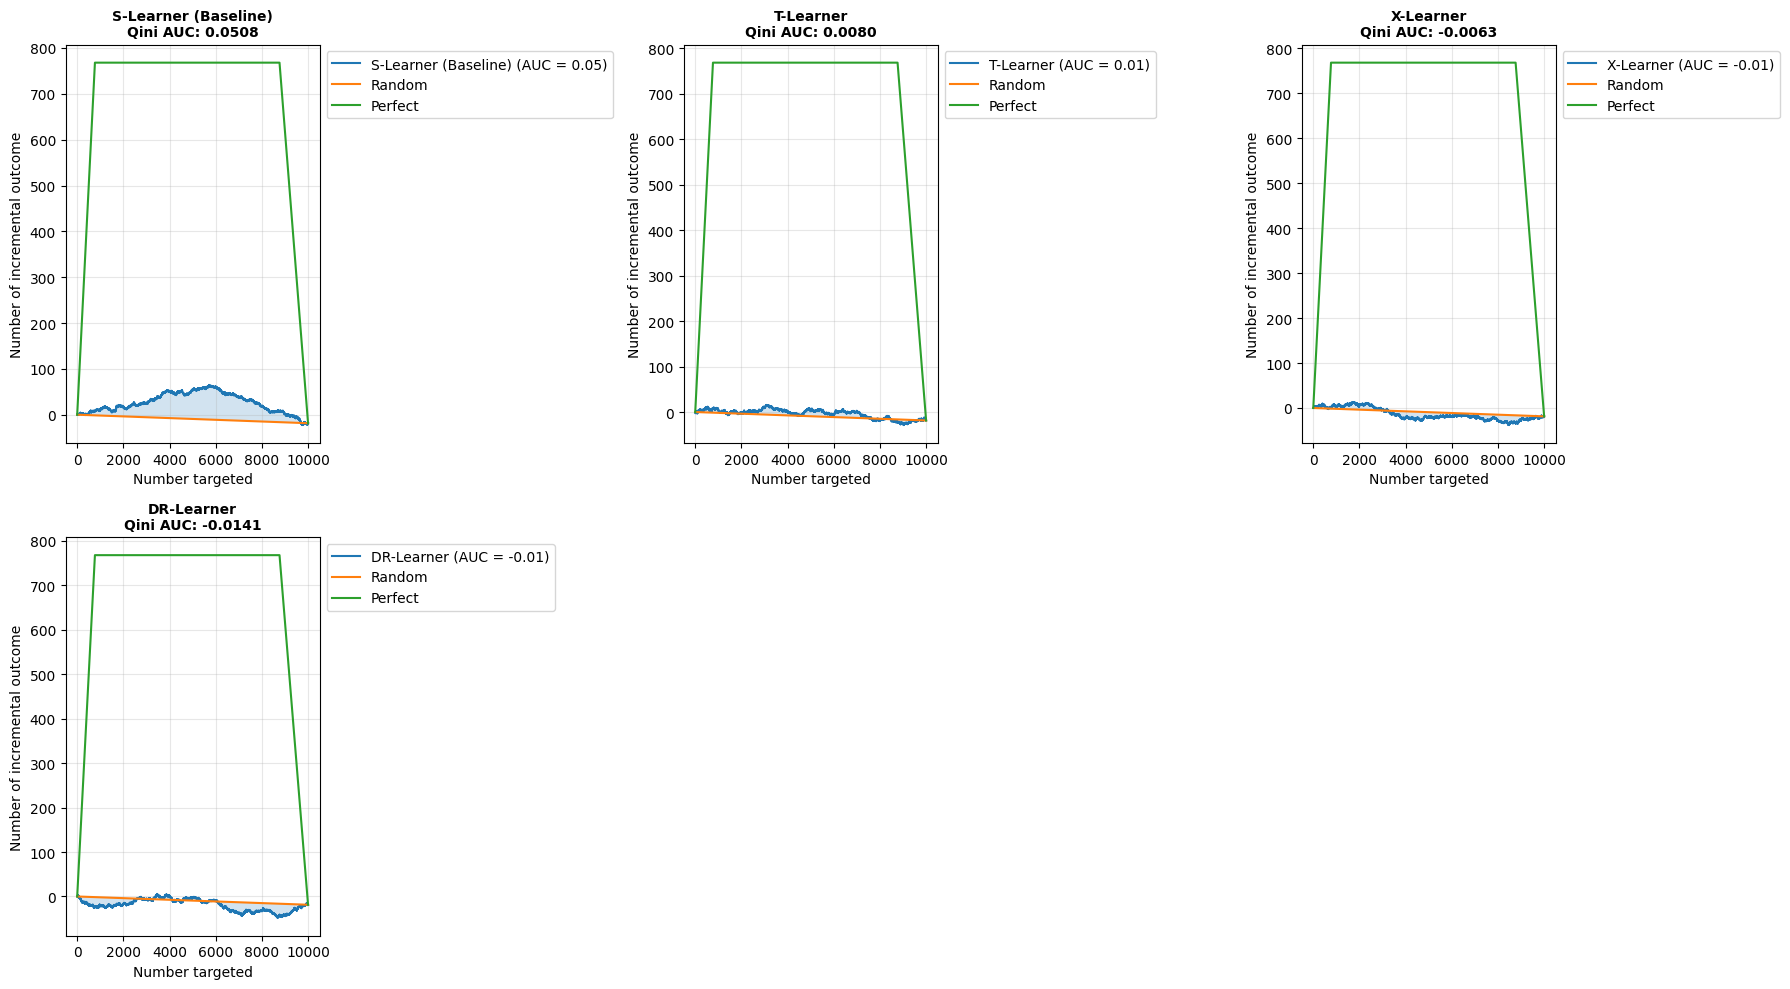

✅ Qini comparison saved to: outputs/meta_learner_qini_comparison_20251116T220142Z.png


In [42]:
## Visualize All Meta-Learners (Qini Curves)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models_viz = [
    ("S-Learner (Baseline)", uplift_test_enet, test_qini_enet),
    ("T-Learner", uplift_test_tlearner, test_qini_tlearner),
    ("X-Learner", uplift_test_xlearner, test_qini_xlearner),
    ("DR-Learner", uplift_test_dr, test_qini_dr),
]


for idx, (name, uplift, qini) in enumerate(models_viz):
    if idx < len(axes):
        plot_qini_curve(
            y_test, uplift, treatment_test, perfect=True, name=name, ax=axes[idx]
        )
        axes[idx].set_title(
            f"{name}\nQini AUC: {qini:.4f}", fontweight="bold", fontsize=10
        )
        axes[idx].grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(models_viz), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"meta_learner_qini_comparison_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Qini comparison saved to: outputs/meta_learner_qini_comparison_{timestamp}.png"
)

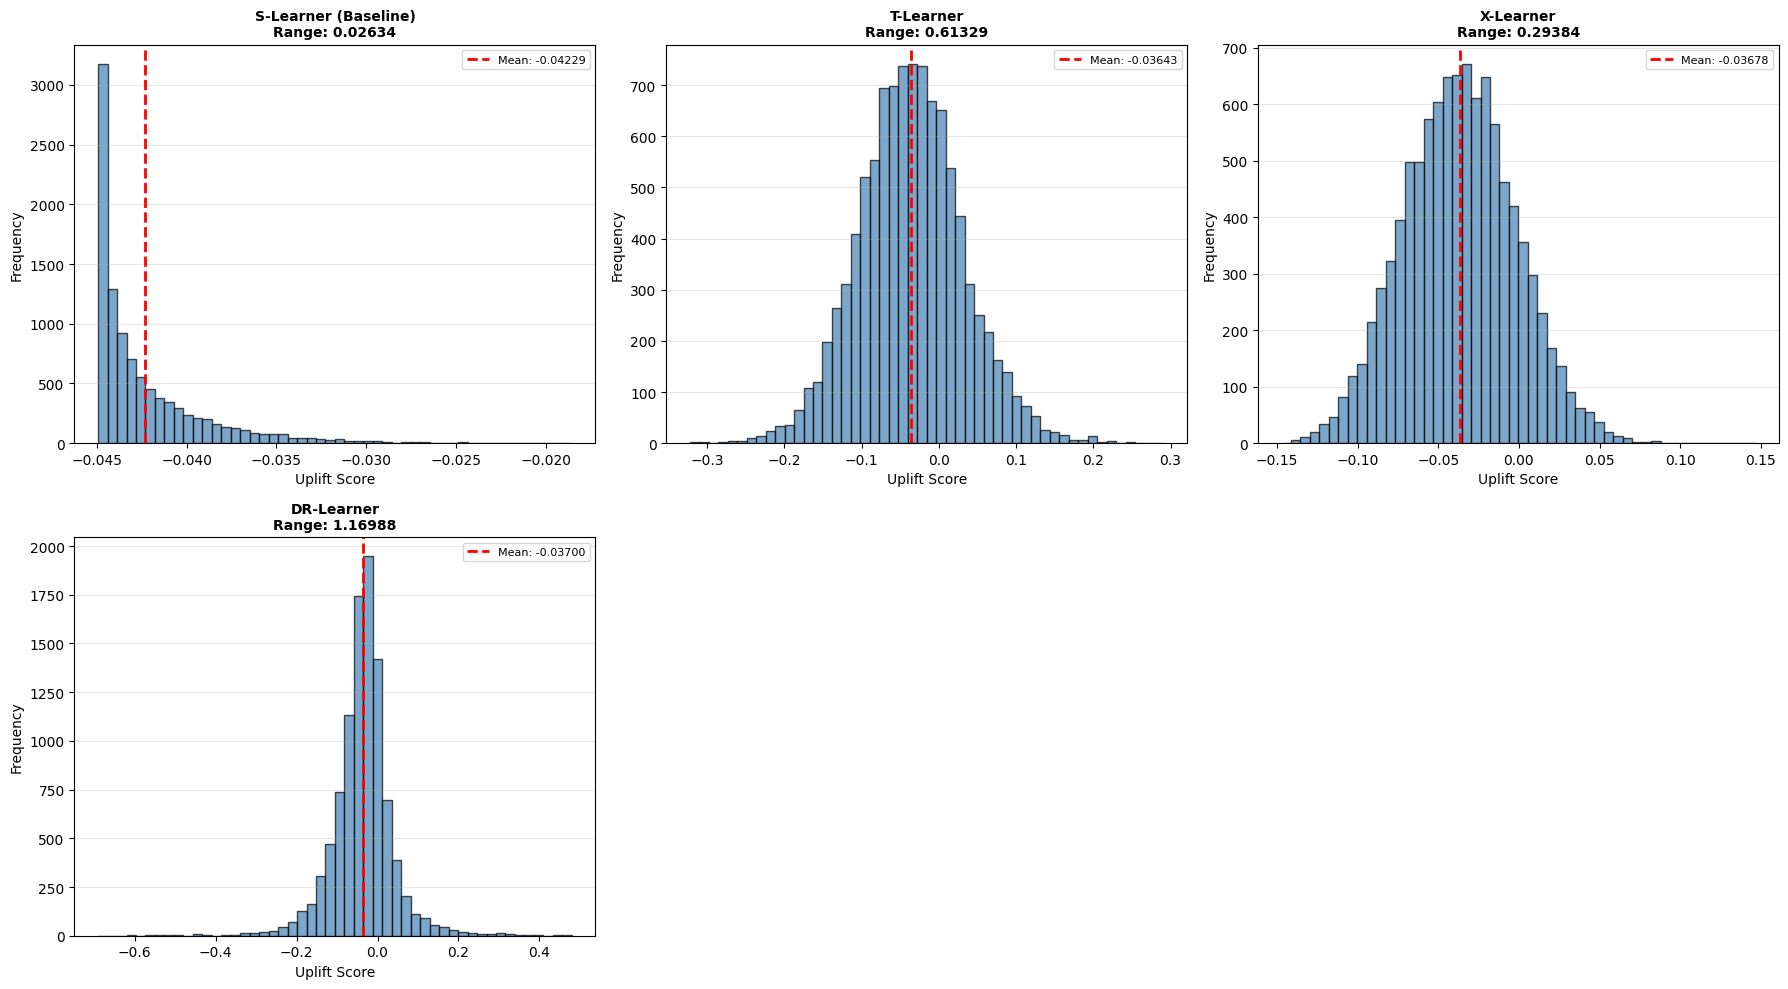

✅ Distribution comparison saved to: outputs/meta_learner_distributions_20251116T220142Z.png


In [44]:
## Uplift Distribution Comparison

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, uplift, _) in enumerate(models_viz):
    if idx < len(axes):
        axes[idx].hist(uplift, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
        axes[idx].axvline(
            uplift.mean(),
            color="red",
            linestyle="--",
            linewidth=2,
            label=f"Mean: {uplift.mean():.5f}",
        )
        axes[idx].set_xlabel("Uplift Score")
        axes[idx].set_ylabel("Frequency")
        axes[idx].set_title(
            f"{name}\nRange: {uplift.max() - uplift.min():.5f}",
            fontweight="bold",
            fontsize=10,
        )
        axes[idx].legend(fontsize=8)
        axes[idx].grid(alpha=0.3, axis="y")

# Hide unused subplots
for idx in range(len(models_viz), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.savefig(
    repo_root / "outputs" / f"meta_learner_distributions_{timestamp}.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print(
    f"✅ Distribution comparison saved to: outputs/meta_learner_distributions_{timestamp}.png"
)